In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from user_agents import parse

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from user_agents import parse

In [2]:
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor

# 1. Data exploration

In [3]:
df = pd.read_csv('unprocessed.csv')
df.head(4)

,ip,time,method,url,requested_file_type,status_code,response_length,user_agent,response_time,label
0,207.213.193.143,2021-5-12T5:6:0.0+0430,Get,/cdn/profiles/1026106239,NaN,304,0,Googlebot-Image/1.0,32,1
1,207.213.193.143,2021-5-12T5:6:0.0+0430,Get,images/badge.png,png,304,0,Googlebot-Image/1.0,4,1
2,35.110.222.153,2021-5-12T5:6:0.0+0430,Get,/pages/630180847,NaN,200,52567,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,32,0
3,35.108.208.99,2021-5-12T5:6:0.0+0430,Get,images/fav_icon2.ico,ico,200,23531,Mozilla/5.0 (Linux; Android 6.0; CAM-L21) Appl...,20,0


In [4]:
df.shape

(1241945, 10)

In [5]:
df[['requested_file_type', 'user_agent']]

,requested_file_type,user_agent
0,NaN,Googlebot-Image/1.0
1,png,Googlebot-Image/1.0
2,NaN,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...
3,ico,Mozilla/5.0 (Linux; Android 6.0; CAM-L21) Appl...
4,png,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...
...,...,...
1241940,png,Mozilla/5.(Linux; Android 9; Redmi 7A) AppleWe...
1241941,woff,Mozilla/5.(Linux; Android 9; Redmi 7A) AppleWe...
1241942,NaN,okhttp/3.12.1
1241943,NaN,Googlebot-Image/1.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1241945 entries, 0 to 1241944
Data columns (total 10 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   ip                   1241945 non-null  object
 1   time                 1241945 non-null  object
 2   method               1241945 non-null  object
 3   url                  1241945 non-null  object
 4   requested_file_type  608061 non-null   object
 5   status_code          1241945 non-null  int64 
 6   response_length      1241945 non-null  object
 7   user_agent           1241382 non-null  object
 8   response_time        1241945 non-null  object
 9   label                1241945 non-null  int64 
dtypes: int64(2), object(8)
memory usage: 94.8+ MB


In [7]:
df.isna().sum()

ip                          0
time                        0
method                      0
url                         0
requested_file_type    633884
status_code                 0
response_length             0
user_agent                563
response_time               0
label                       0
dtype: int64

<AxesSubplot:>

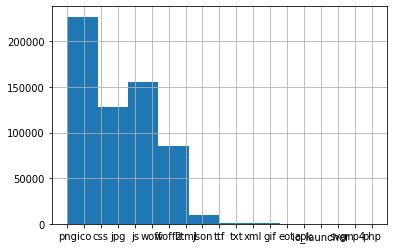

In [8]:
df['requested_file_type'].hist()

Since our goal is to identify crawlers, the type of requested file is not very important, and since the number of missing values is very large, it is not logical to delete them.
Therefore, we fill the missing values equal to the most frequent value that is PNG

In [9]:
df['requested_file_type'] = df['requested_file_type'].fillna('png')

In [10]:
df.isna().sum()

ip                       0
time                     0
method                   0
url                      0
requested_file_type      0
status_code              0
response_length          0
user_agent             563
response_time            0
label                    0
dtype: int64

In [11]:
df[df["user_agent"].isna()]

,ip,time,method,url,requested_file_type,status_code,response_length,user_agent,response_time,label
999,35.124.160.15,2021-5-12T5:6:47.0+0430,Get,images/appSlider/third.jpg,jpg,200,73[[Mozilla/5.0,NaN,(Linux; Android 8.0.0; SM-G570F) AppleWebKit/5...,0
14643,180.16.46.235,2021-5-12T5:17:21.0+0430,Get,images/appSlider/third.jpg,jpg,200,73[[Mozilla/5.0,NaN,(Linux; Android 6.0; ALE-L21) AppleWebKit/537....,0
15525,35.109.119.97,2021-5-12T5:18:8.0+0430,Get,images/appSlider/third.jpg,jpg,200,73[[Mozilla/5.0,NaN,(Linux; Android 11; SM-A505F) AppleWebKit/537....,0
26870,67.38.88.127,2021-5-12T5:28:26.0+0430,Get,/cdn/gadgets/754515939,png,200,127[[Mozilla/5.0,NaN,(Linux; Android 9; SAMSUNG SM-J701F) AppleWebK...,0
51074,14.62.137.148,2021-5-12T5:47:12.0+0430,Get,images/appSlider/third.jpg,jpg,200,73[[Mozilla/5.0,NaN,(Linux; Android 8.1.0; SM-J410F) AppleWebKit/5...,0
...,...,...,...,...,...,...,...,...,...,...
1227904,92.130.218.56,2021-5-12T15:2:46.0+0430,Get,images/appSlider/third.jpg,jpg,200,73[[Mozilla/5.0,NaN,(Linux; Android 7.0; SM-G920F) AppleWebKit/537...,0
1228372,4.0.51.74,2021-5-12T15:2:59.0+0430,Get,/cdn/profiles/392547969,png,200,2[[Mozilla/5.0,NaN,(Linux; Android 5.1; HUAWEI LUA-U22 Build/HUAW...,0
1231583,14.9.62.72,2021-5-12T15:4:13.0+0430,Get,images/appSlider/third.jpg,jpg,200,73[[Mozilla/5.0,NaN,(Linux; Android 10; SM-A013G Build/QP1A.190711...,0
1235135,207.204.63.220,2021-5-12T15:5:38.0+0430,Get,images/appSlider/third.jpg,jpg,200,73[[Mozilla/5.0,NaN,"(X11; Linux x86_64) AppleWebKit/537.36 (KHTML,...",0


Because the number of missing user agent is small in scale with the total values, and also logically, filling it can be very important for crawler detection, as we can see in the dataset in the rows where the user agent value is missing, URL and Similar response lengths are found, which we assume to be crawling and remove them

In [12]:
df.drop(df[df['user_agent'].isna()].index, inplace = True)

In [13]:
df.isna().sum()

ip                     0
time                   0
method                 0
url                    0
requested_file_type    0
status_code            0
response_length        0
user_agent             0
response_time          0
label                  0
dtype: int64

Now we check other features that can take Nan values, such as empty URLs

In [14]:
df[df["url"] == ""].size

0

In [15]:
df[df['response_time'] == '-'].size

17170

Because the response time is the time it takes to send the server's response to the client, it is not very important to detect the web crawler, so we fill it with a value of 0.

In [16]:
df['response_time'] = df['response_time'].replace('-', 0)

In [17]:
df.shape

(1241382, 10)

## 1.1The most commons

### 1.1.1 The most visited IP address

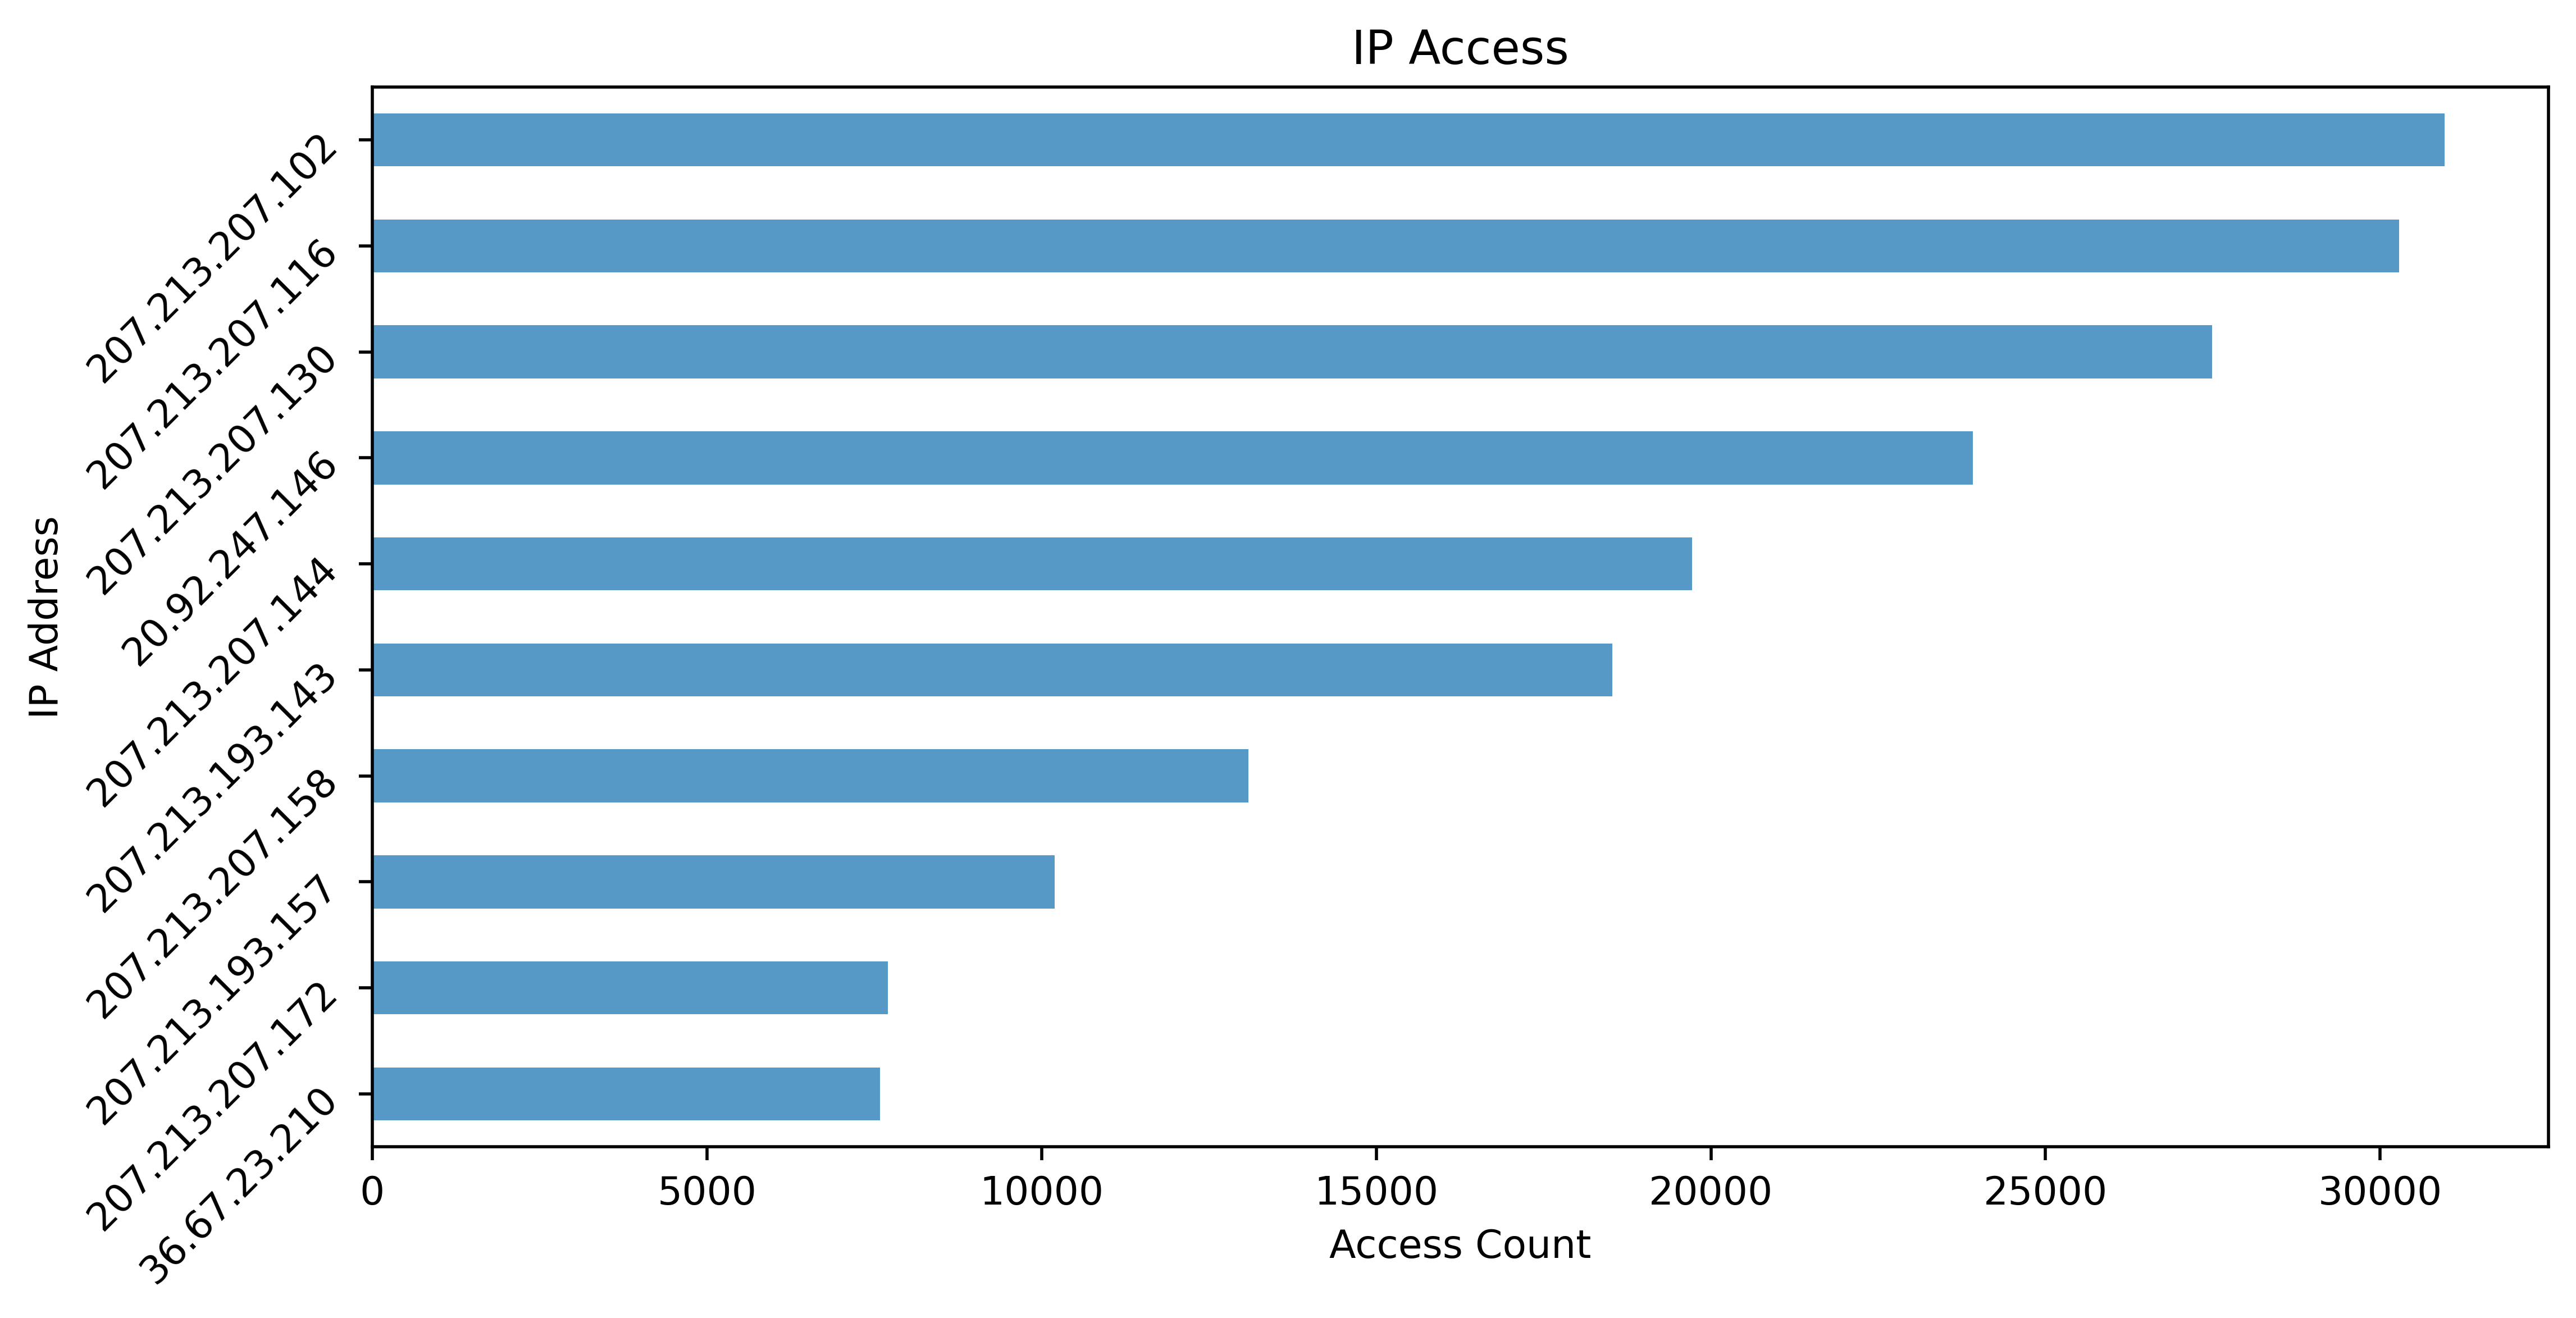

In [18]:
def top_ip(df, n=10):
    ip = df.groupby('ip')['ip'].agg(len)
    sorted_ip = ip.sort_values()[-n:]
    fig = plt.figure(figsize=(10,5), dpi=500)
    ax = sorted_ip.plot(kind='barh', title='IP Access', rot=45, alpha=0.75)
    ax.set_xlabel('Access Count')
    ax.set_ylabel('IP Address')
    

top_ip(df, n=10)

In [19]:
ip = df.groupby('ip')['ip'].agg(len)
sorted_ip = ip.sort_values()[-10:]
df[df['ip'] == '207.213.207.102']

,ip,time,method,url,requested_file_type,status_code,response_length,user_agent,response_time,label
94007,207.213.207.102,2021-5-12T6:25:56.0+0430,Get,/cdn/articles/1148001967,png,304,0,Googlebot-Image/1.0,16,1
150093,207.213.207.102,2021-5-12T7:53:23.0+0430,Get,/cdn/pro_photo_gallery/1647737278,png,304,0,Googlebot-Image/1.0,28,1
150739,207.213.207.102,2021-5-12T7:54:1.0+0430,Get,/cdn/articles/1258441802,png,304,0,Googlebot-Image/1.0,20,1
167464,207.213.207.102,2021-5-12T8:11:24.0+0430,Get,/cdn/pro_photo_gallery/2005389343,png,304,0,Googlebot-Image/1.0,16,1
274909,207.213.207.102,2021-5-12T9:23:9.0+0430,Get,/cdn/articles/1663054446,png,304,0,Googlebot-Image/1.0,20,1
...,...,...,...,...,...,...,...,...,...,...
1241849,207.213.207.102,2021-5-12T15:8:56.0+0430,Get,/best_pros/1331986151,png,200,60429,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...,152,1
1241850,207.213.207.102,2021-5-12T15:8:56.0+0430,Get,/amp/order/670781382/1990297374,png,200,103370,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...,116,1
1241866,207.213.207.102,2021-5-12T15:8:57.0+0430,Get,/cdn/profiles/1087372774,png,304,0,Googlebot-Image/1.0,12,1
1241885,207.213.207.102,2021-5-12T15:8:58.0+0430,Get,/cdn/pro_photo_gallery/1818326365,png,304,0,Googlebot-Image/1.0,36,1


### 1.1.2 The most requested endpoints

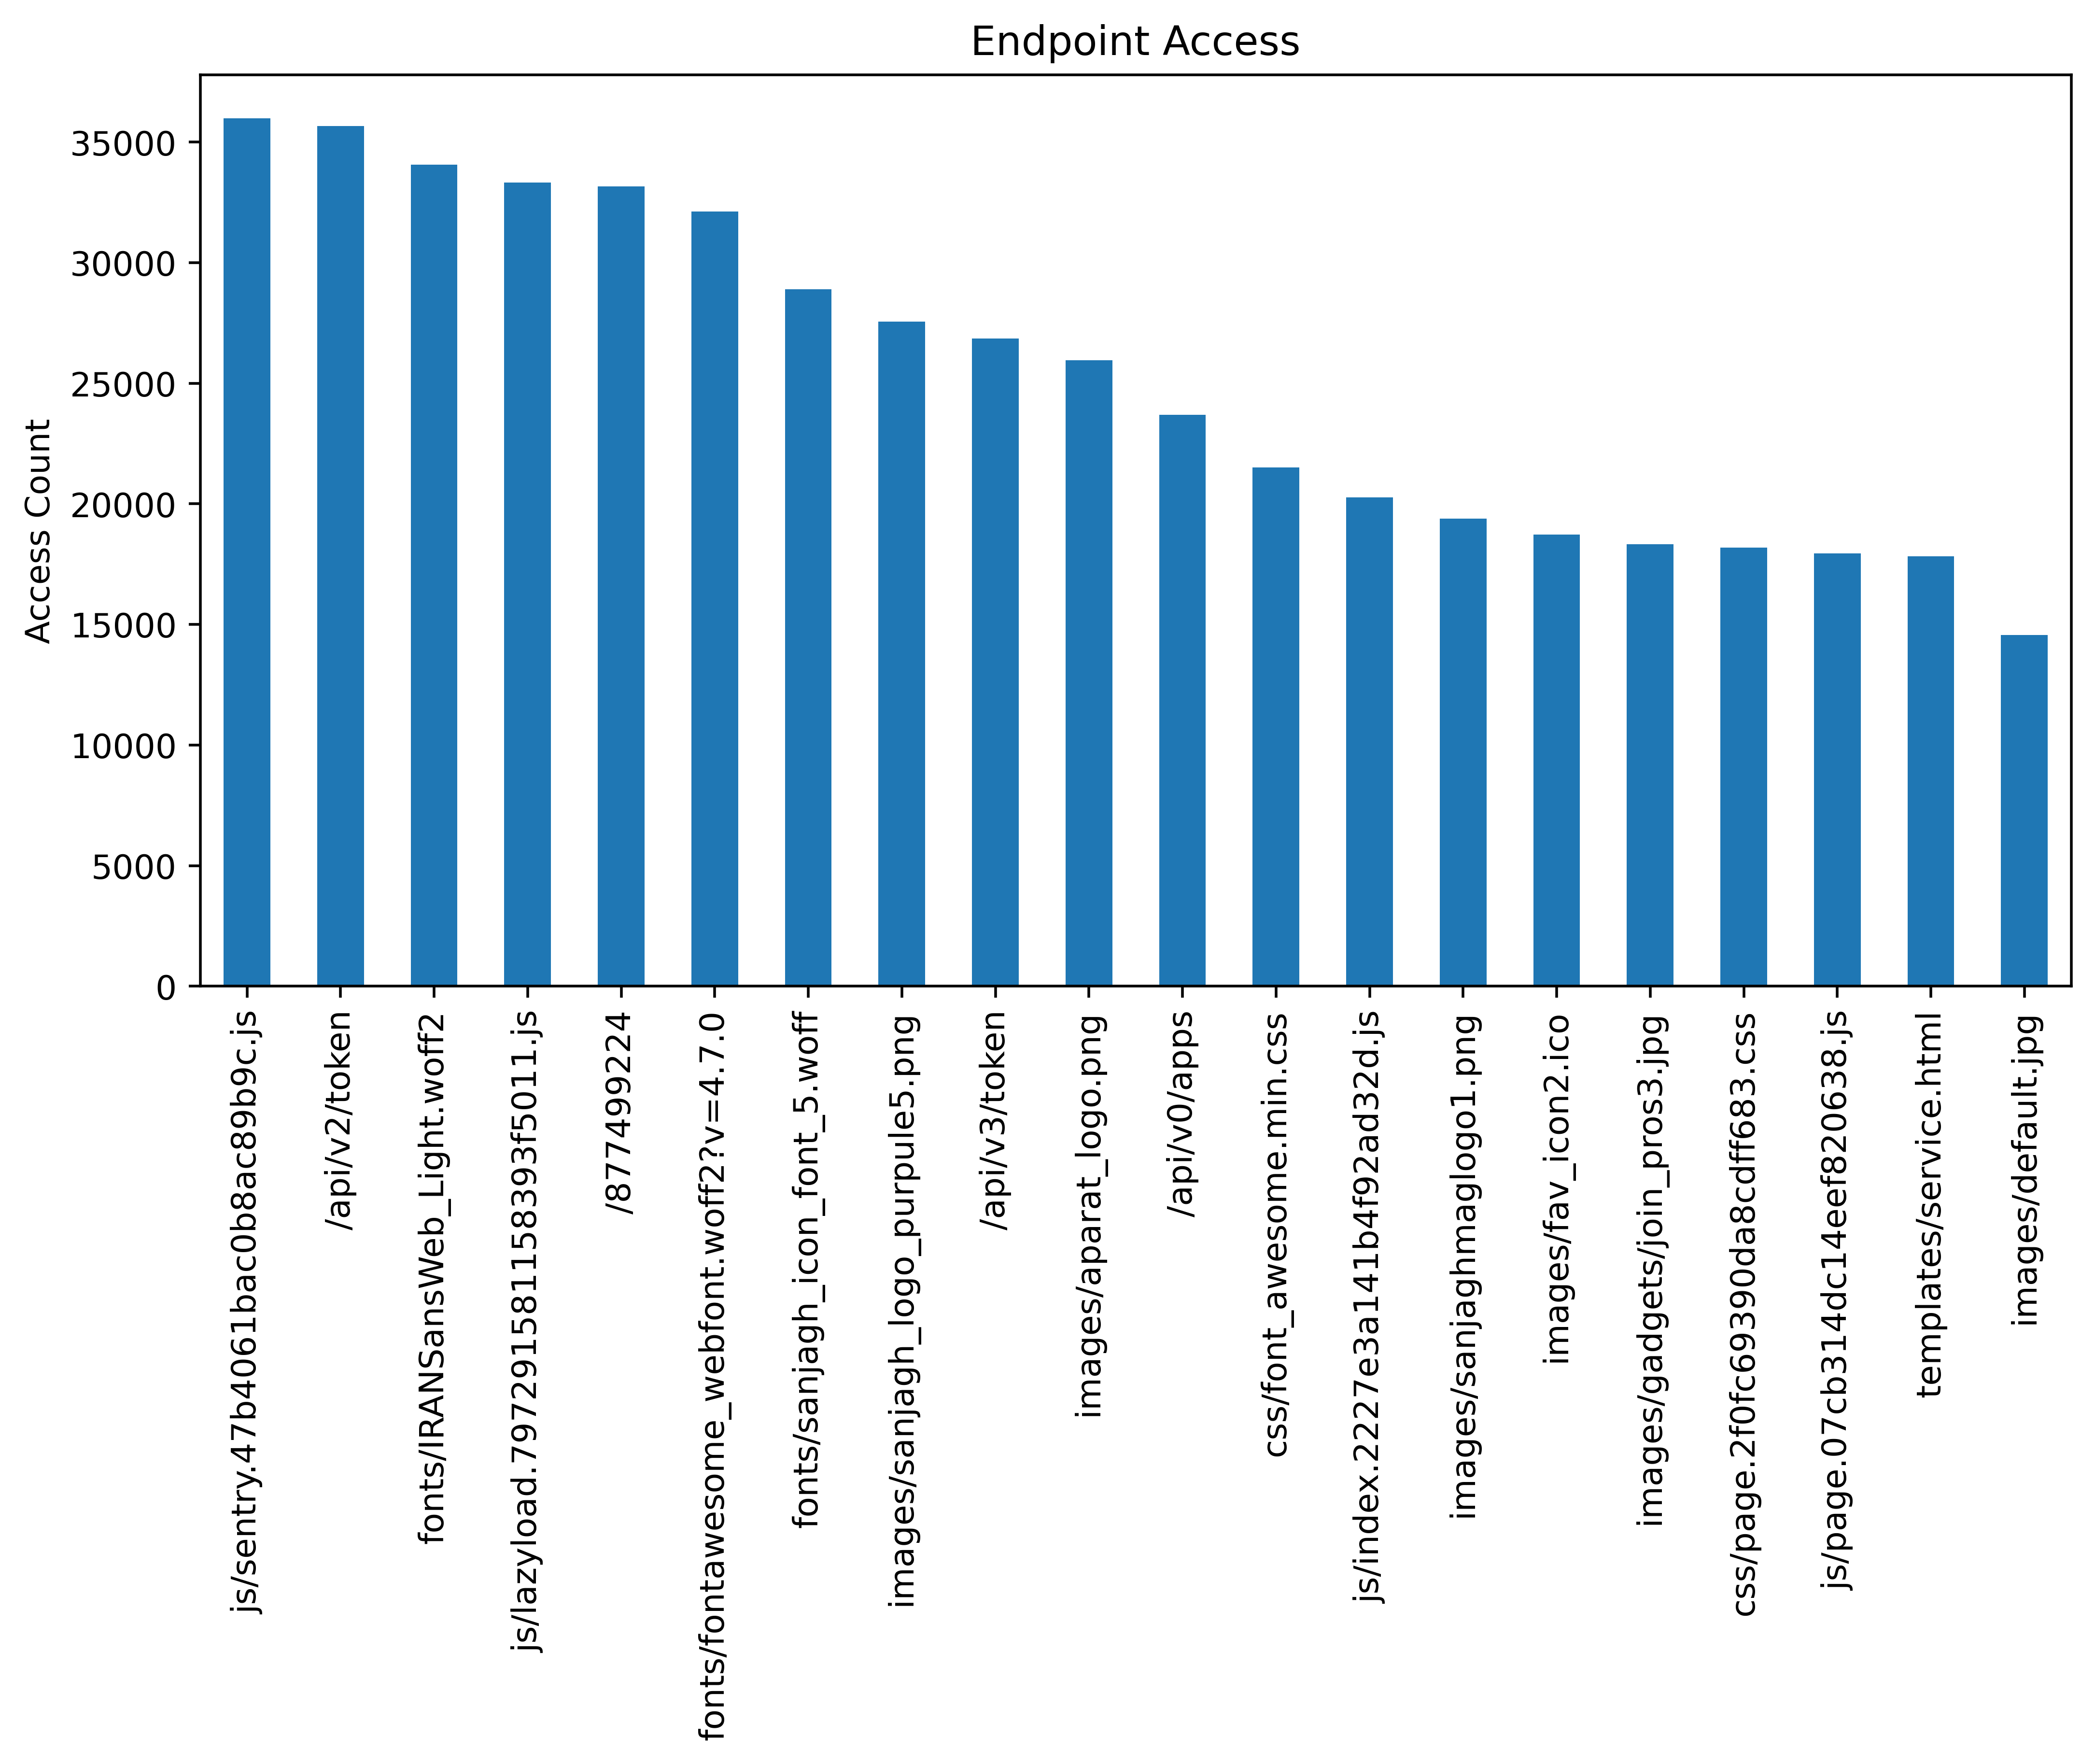

In [20]:
def top_request_endpoint(df, n=10):
    path = df['url']
    fig = plt.figure(figsize=(10,5), dpi=500)
    ax = path.value_counts()[:n].plot(kind='bar', title='Endpoint Access')
    ax.set_ylabel('Access Count')
    
top_request_endpoint(df, n=20)


Now let's add a column into the main dataframe which indicates the normalized **count of the path for each request**.

In [21]:
# note that "len" counts the NaN value as well.
df['url_count_normalized'] = df.groupby(['url'])['url'].transform(len)
df['url_count_normalized'] = (df['url_count_normalized'] / len(df)) * 100

df.sort_values('url_count_normalized', ascending=True)


,ip,time,method,url,requested_file_type,status_code,response_length,user_agent,response_time,label,url_count_normalized
620974,207.213.57.144,2021-5-12T11:58:52.0+0430,Get,/cdn/pro_photo_gallery/1705836568,png,200,2495,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...,20,0,0.000081
103601,25.29.149.29,2021-5-12T6:40:40.0+0430,Get,/order/1437493832/543694622,png,301,0,Mozilla/5.(compatible; bingbot/2.0; +http://ww...,52,1,0.000081
103600,86.151.148.5,2021-5-12T6:40:40.0+0430,Get,/pros/305849146,png,200,59599,Mozilla/5.0 (Linux; Android 10; Redmi Note 9 P...,228,0,0.000081
551487,155.114.229.186,2021-5-12T11:30:32.0+0430,Get,/api/v2/connect/330932816,png,101,9448,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,113762,0,0.000081
551497,127.227.218.254,2021-5-12T11:30:33.0+0430,Get,/api/v2/connect/563572024,png,101,13803,okhttp/3.12.1,62131,0,0.000081
...,...,...,...,...,...,...,...,...,...,...,...
456995,35.251.122.164,2021-5-12T10:49:14.0+0430,Get,js/sentry.47b4061bac0b8ac89b9c.js,js,304,0,Mozilla/5.(iPhone; CPU iPhone OS 12_5_3 like M...,0,0,2.899349
814297,35.3.76.174,2021-5-12T12:54:47.0+0430,Get,js/sentry.47b4061bac0b8ac89b9c.js,js,200,65059,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:89...,8,0,2.899349
13750,127.227.102.13,2021-5-12T5:16:36.0+0430,Get,js/sentry.47b4061bac0b8ac89b9c.js,js,200,65059,Mozilla/5.0 (Linux; Android 4.4.2; HTC_D626ph ...,4,0,2.899349
814444,35.136.175.190,2021-5-12T12:54:49.0+0430,Get,js/sentry.47b4061bac0b8ac89b9c.js,js,200,65059,Mozilla/5.0 (Linux; Android 10; SM-A105F) Appl...,8,0,2.899349


### 1.1.3 HTTP method with the most requests

In [22]:
df['method'].unique()

array(['Get', 'Head', 'Post', 'Put', 'Options'], dtype=object)

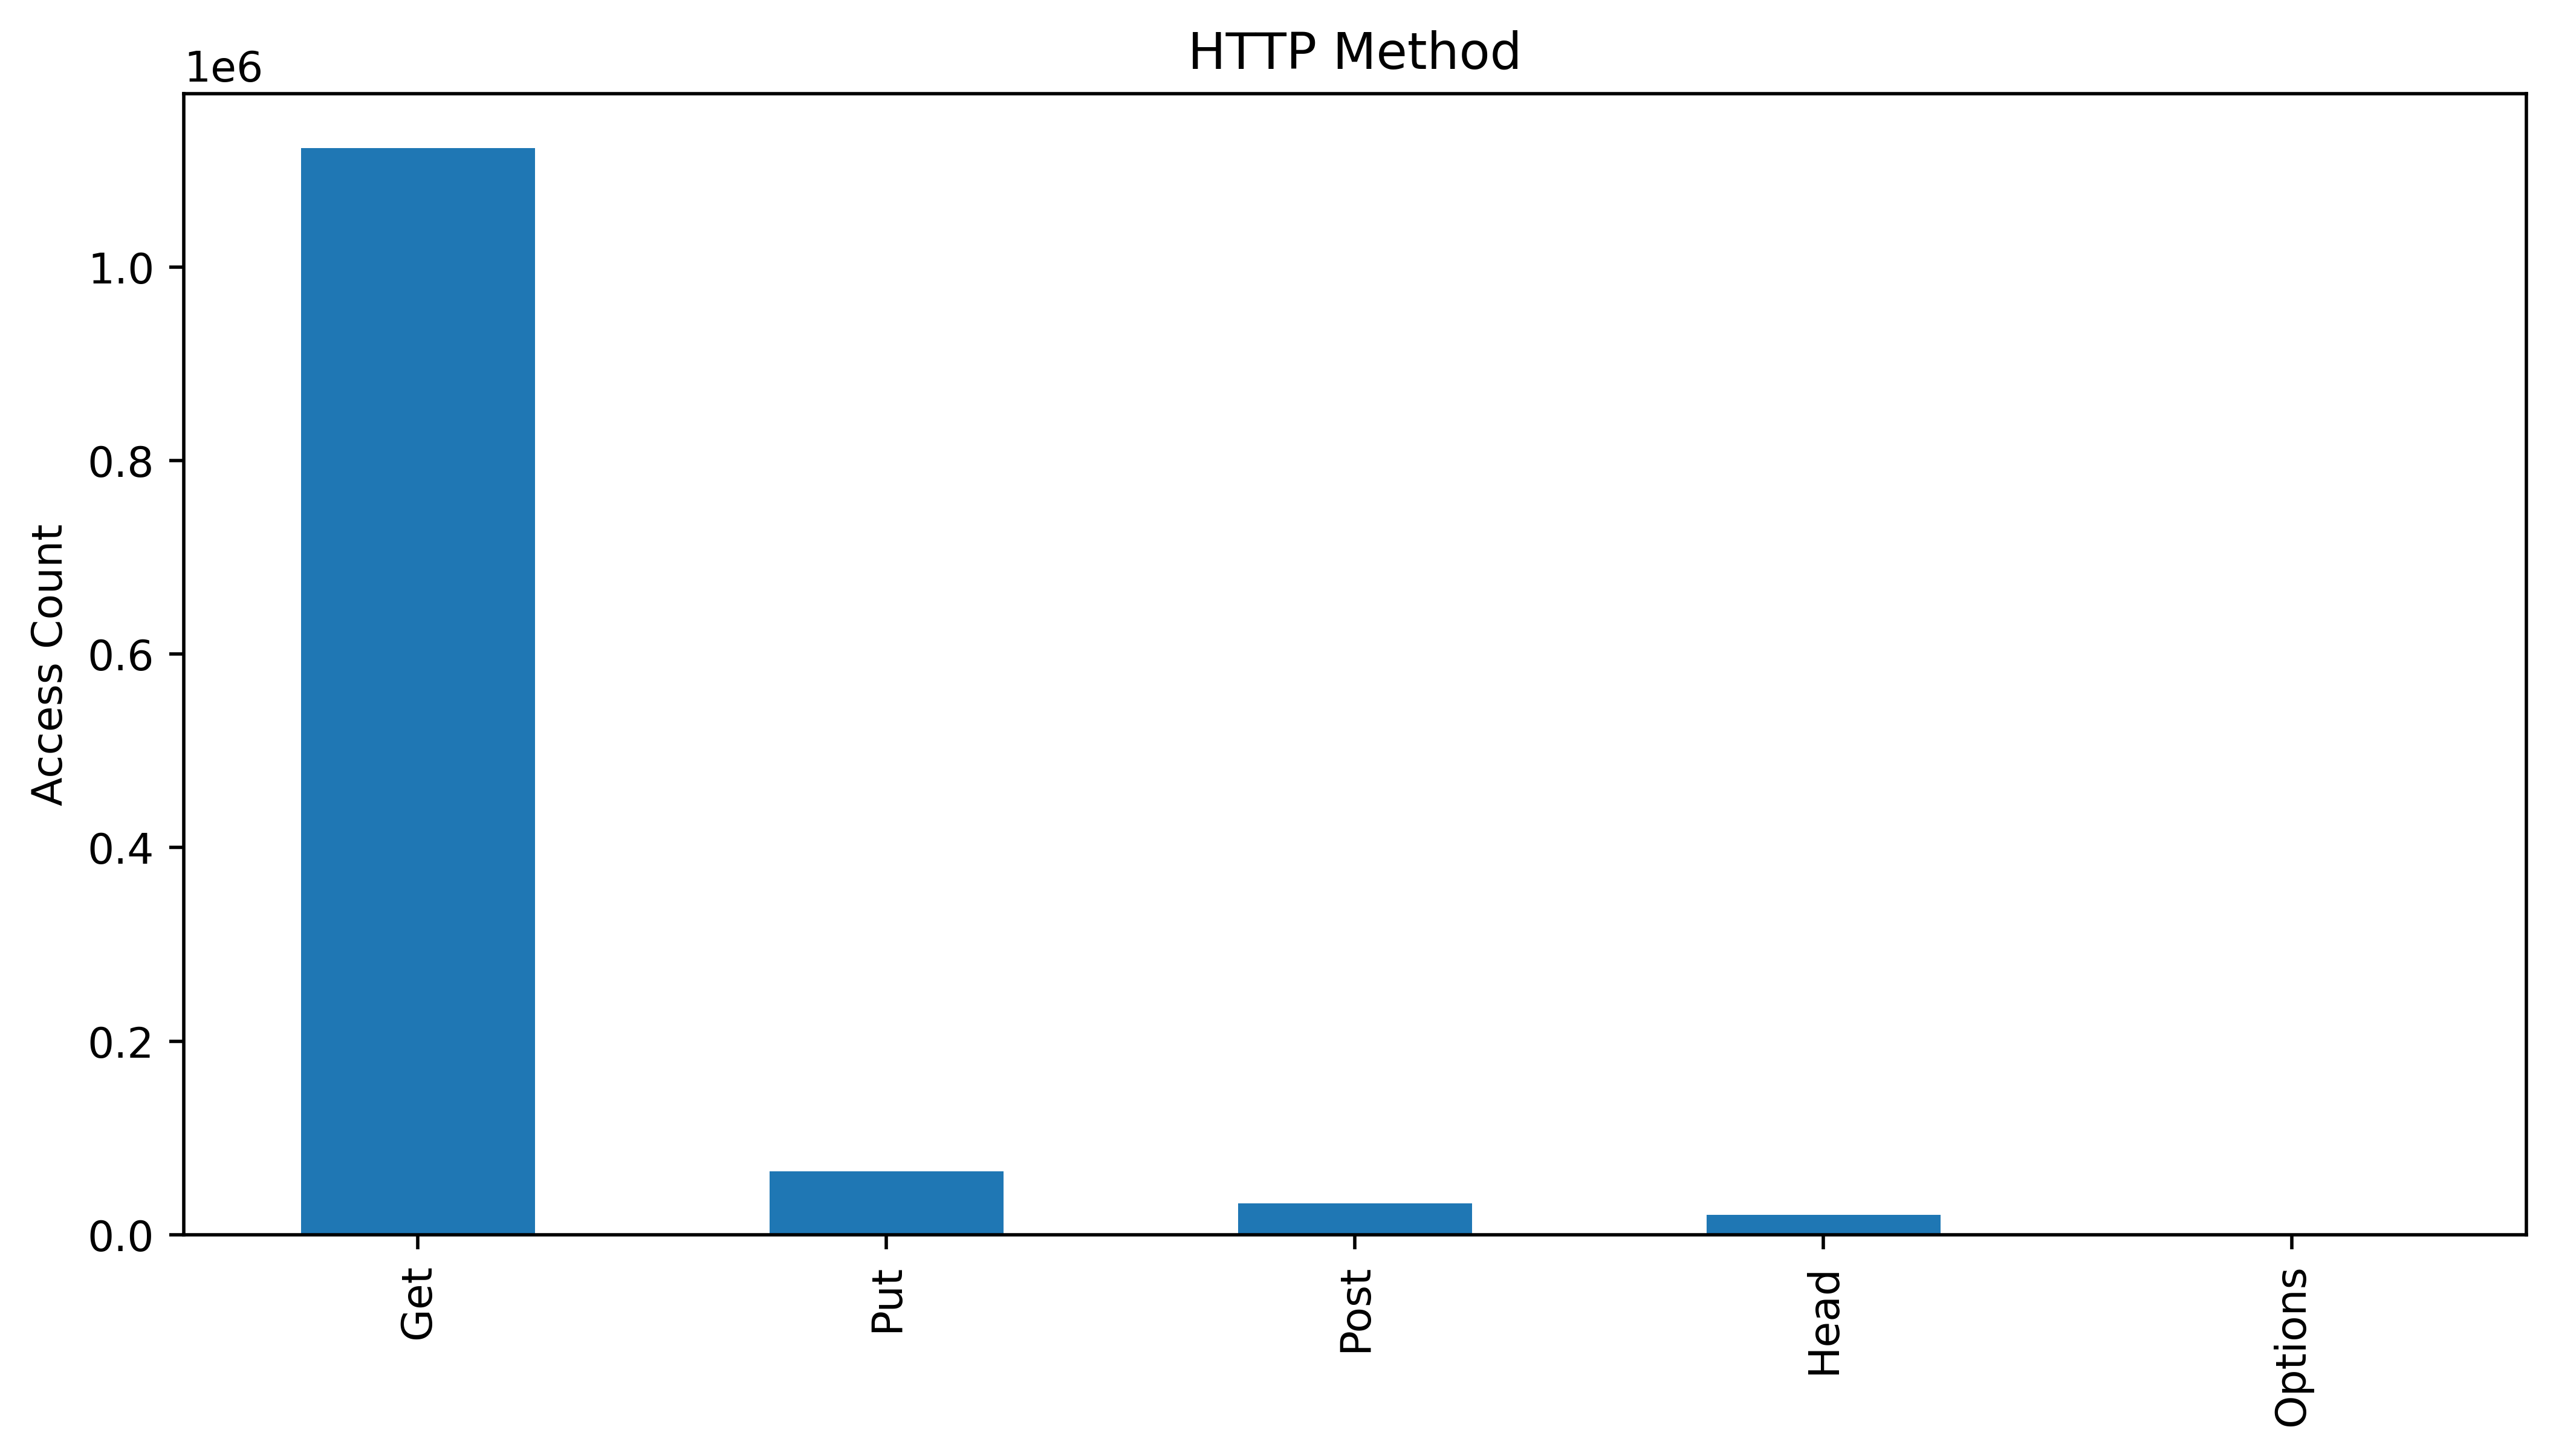

In [23]:
def top_request_method(df):
    method = df['method']
    fig = plt.figure(figsize=(10,5), dpi=500)
    ax = method.value_counts().plot(kind='bar', title='HTTP Method')
    ax.set_ylabel('Access Count')
    plt.show()
    
top_request_method(df)

### 1.1.4 The most common user agents

First of all, lets add some useful features which can be adapted from the raw user agent. We used [user agents library](https://pypi.org/project/user-agents/) for this purpose.

In [24]:
# set the user agent browser family for each request
df['browser'] = df['user_agent'].apply(lambda x : parse(x).browser.family)
# set the user agent os family for each request
df['os'] = df['user_agent'].apply(lambda x : parse(x).os.family)
# check if the request is from a bot or not!
df['is_bot'] = df['user_agent'].apply(lambda x : parse(x).is_bot)
# check if the request is from a pc or not!
df['is_pc'] = df['user_agent'].apply(lambda x : parse(x).is_pc)

df

,ip,time,method,url,requested_file_type,status_code,response_length,user_agent,response_time,label,url_count_normalized,browser,os,is_bot,is_pc
0,207.213.193.143,2021-5-12T5:6:0.0+0430,Get,/cdn/profiles/1026106239,png,304,0,Googlebot-Image/1.0,32,1,0.011439,Googlebot-Image,Other,True,False
1,207.213.193.143,2021-5-12T5:6:0.0+0430,Get,images/badge.png,png,304,0,Googlebot-Image/1.0,4,1,1.009601,Googlebot-Image,Other,True,False
2,35.110.222.153,2021-5-12T5:6:0.0+0430,Get,/pages/630180847,png,200,52567,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,32,0,0.101178,Samsung Internet,Android,False,False
3,35.108.208.99,2021-5-12T5:6:0.0+0430,Get,images/fav_icon2.ico,ico,200,23531,Mozilla/5.0 (Linux; Android 6.0; CAM-L21) Appl...,20,0,1.509205,Chrome Mobile,Android,False,False
4,35.110.222.153,2021-5-12T5:6:0.0+0430,Get,images/sanjagh_logo_purpule5.png,png,200,4680,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,8,0,2.219704,Samsung Internet,Android,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1241940,35.117.86.75,2021-5-12T15:8:59.0+0430,Get,images/graystar_min.png,png,304,0,Mozilla/5.(Linux; Android 9; Redmi 7A) AppleWe...,4,0,1.068648,Chrome Mobile,Android,False,False
1241941,35.117.86.75,2021-5-12T15:8:59.0+0430,Get,fonts/sanjagh_icon_font_5.woff,woff,304,0,Mozilla/5.(Linux; Android 9; Redmi 7A) AppleWe...,4,0,2.327406,Chrome Mobile,Android,False,False
1241942,153.126.251.199,2021-5-12T15:8:59.0+0430,Get,/api/v2/connect/215865643,png,101,0,okhttp/3.12.1,60003,0,0.000081,okhttp,Other,False,False
1241943,207.213.207.102,2021-5-12T15:8:59.0+0430,Get,/cdn/profiles/1289255230,png,304,0,Googlebot-Image/1.0,20,1,0.000564,Googlebot-Image,Other,True,False


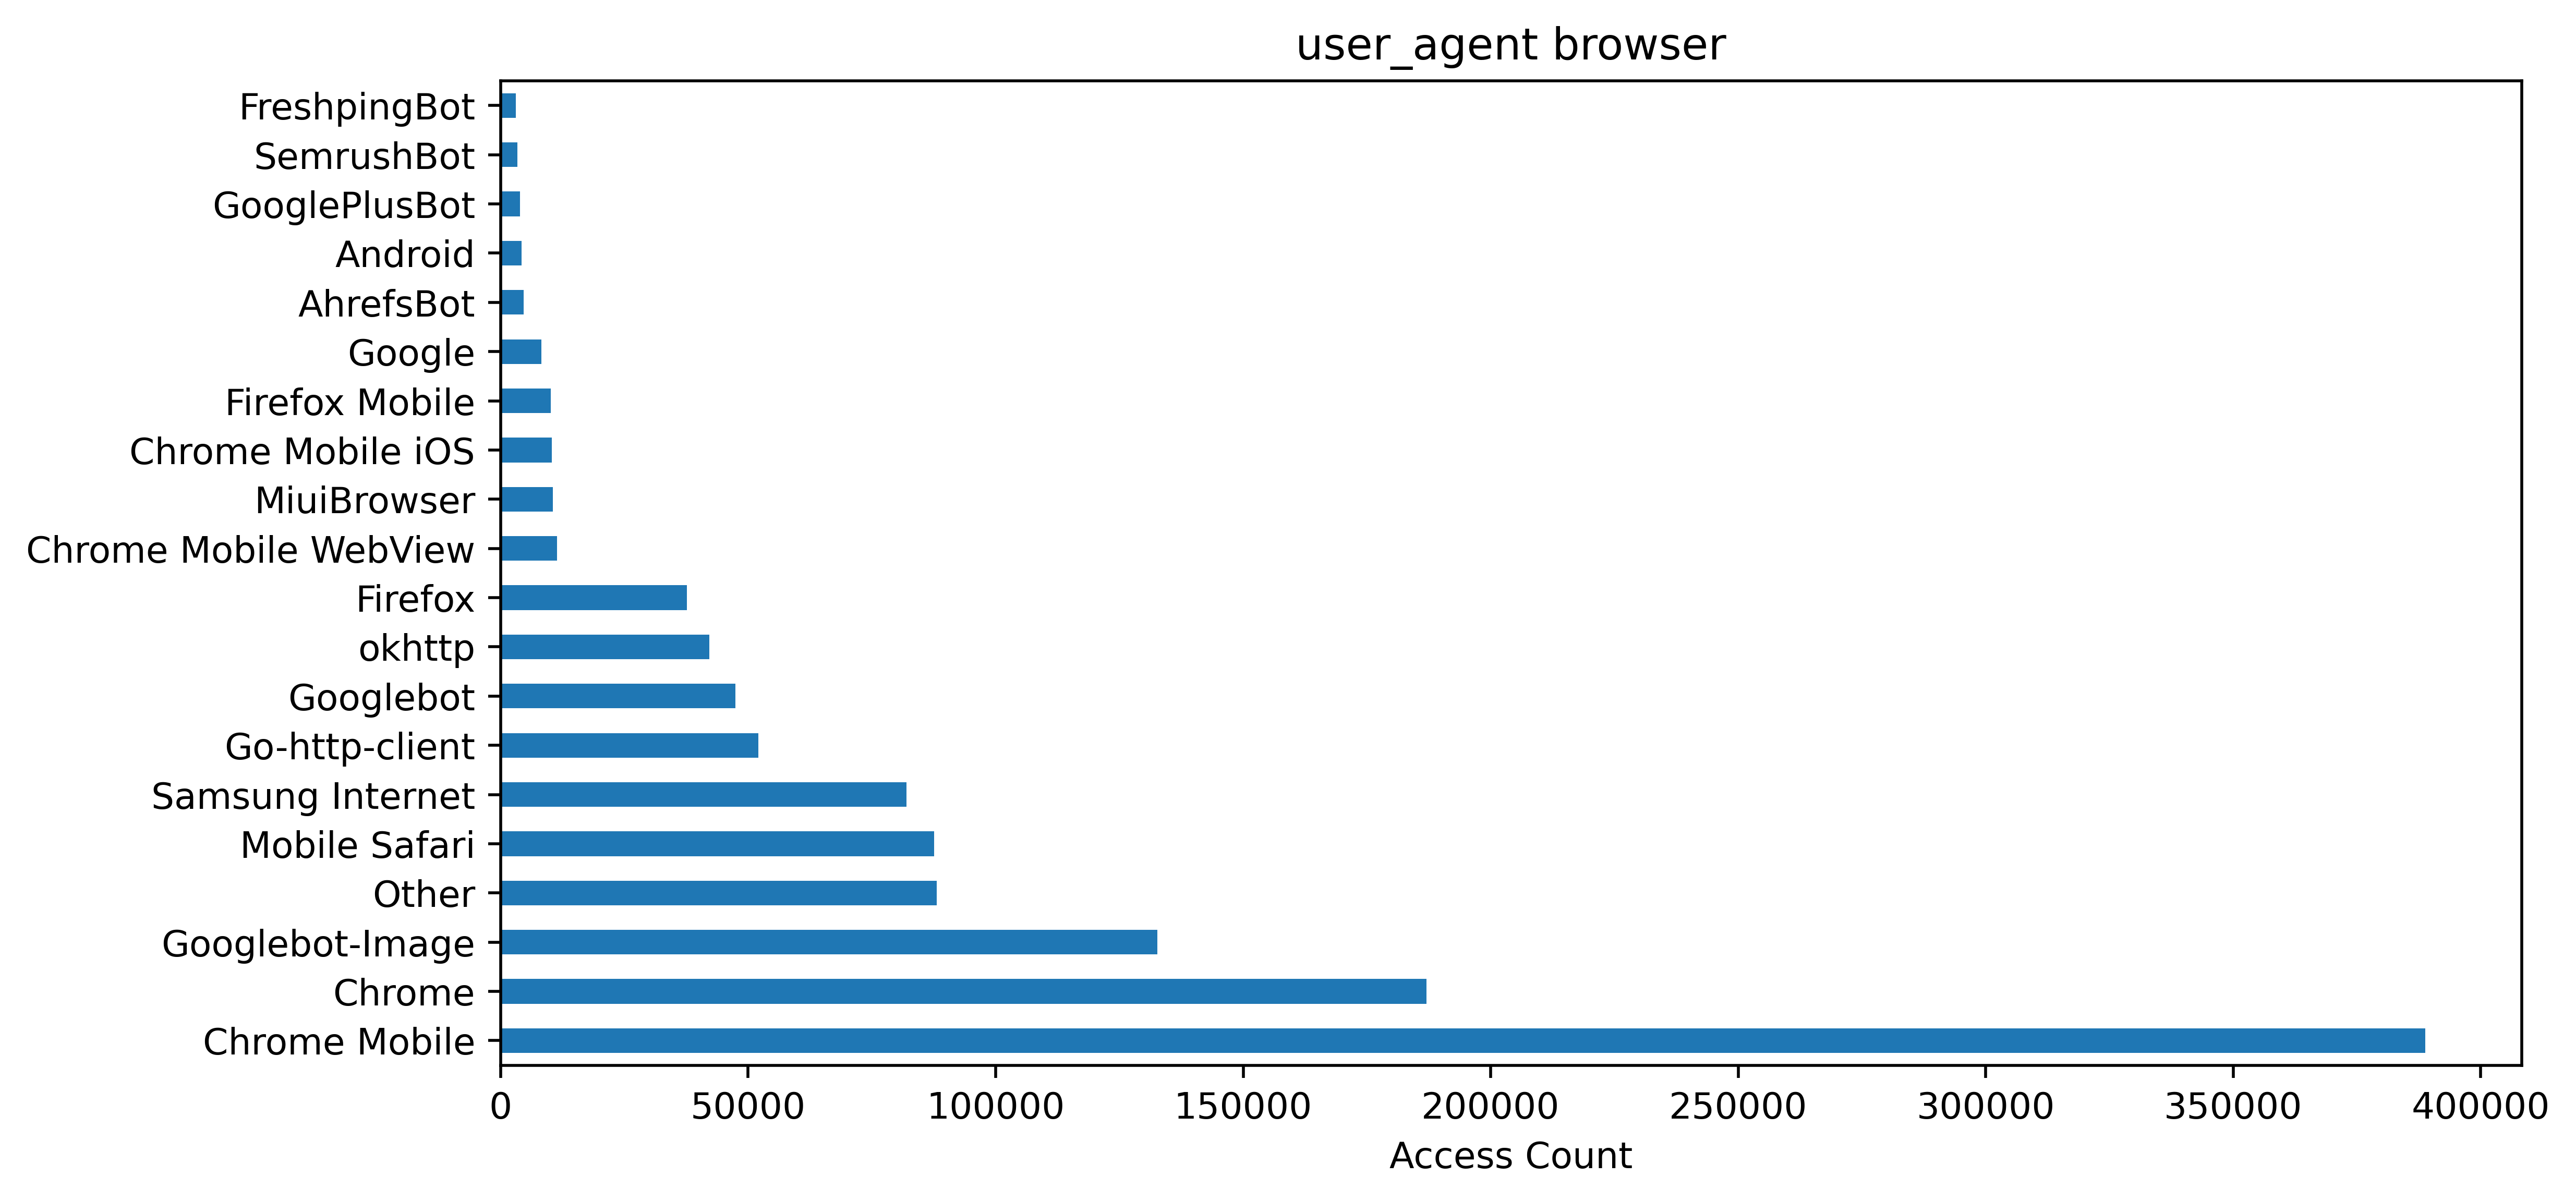

In [25]:
def top_user_agent(df, n=10):
    user_agent_browser = df['browser']
    fig = plt.figure(figsize=(10,5), dpi=500)
    ax = user_agent_browser.value_counts()[:n].plot(kind='barh', title='user_agent browser')
    ax.set_xlabel('Access Count')
    plt.show()
    
top_user_agent(df, n=20)

Now let's add 2 column into the main dataframe which indicates the normalized **count of the browser and os for each request**.

In [26]:
# note that "len" counts the NaN value as well.
df['browser_norm'] = df.groupby(['browser'])['browser'].transform(len)
df['browser_norm'] = (df['browser_norm'] / len(df)) * 100

df['os_norm'] = df.groupby(['os'])['os'].transform(len)
df['os_norm'] = (df['os_norm'] / len(df)) * 100

df

,ip,time,method,url,requested_file_type,status_code,response_length,user_agent,response_time,label,url_count_normalized,browser,os,is_bot,is_pc,browser_norm,os_norm
0,207.213.193.143,2021-5-12T5:6:0.0+0430,Get,/cdn/profiles/1026106239,png,304,0,Googlebot-Image/1.0,32,1,0.011439,Googlebot-Image,Other,True,False,10.690666,21.747858
1,207.213.193.143,2021-5-12T5:6:0.0+0430,Get,images/badge.png,png,304,0,Googlebot-Image/1.0,4,1,1.009601,Googlebot-Image,Other,True,False,10.690666,21.747858
2,35.110.222.153,2021-5-12T5:6:0.0+0430,Get,/pages/630180847,png,200,52567,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,32,0,0.101178,Samsung Internet,Android,False,False,6.603930,48.631042
3,35.108.208.99,2021-5-12T5:6:0.0+0430,Get,images/fav_icon2.ico,ico,200,23531,Mozilla/5.0 (Linux; Android 6.0; CAM-L21) Appl...,20,0,1.509205,Chrome Mobile,Android,False,False,31.322188,48.631042
4,35.110.222.153,2021-5-12T5:6:0.0+0430,Get,images/sanjagh_logo_purpule5.png,png,200,4680,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,8,0,2.219704,Samsung Internet,Android,False,False,6.603930,48.631042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1241940,35.117.86.75,2021-5-12T15:8:59.0+0430,Get,images/graystar_min.png,png,304,0,Mozilla/5.(Linux; Android 9; Redmi 7A) AppleWe...,4,0,1.068648,Chrome Mobile,Android,False,False,31.322188,48.631042
1241941,35.117.86.75,2021-5-12T15:8:59.0+0430,Get,fonts/sanjagh_icon_font_5.woff,woff,304,0,Mozilla/5.(Linux; Android 9; Redmi 7A) AppleWe...,4,0,2.327406,Chrome Mobile,Android,False,False,31.322188,48.631042
1241942,153.126.251.199,2021-5-12T15:8:59.0+0430,Get,/api/v2/connect/215865643,png,101,0,okhttp/3.12.1,60003,0,0.000081,okhttp,Other,False,False,3.394282,21.747858
1241943,207.213.207.102,2021-5-12T15:8:59.0+0430,Get,/cdn/profiles/1289255230,png,304,0,Googlebot-Image/1.0,20,1,0.000564,Googlebot-Image,Other,True,False,10.690666,21.747858


In [27]:
print(*df.columns, sep = '\n')

ip
time
method
url
requested_file_type
status_code
response_length
user_agent
response_time
label
url_count_normalized
browser
os
is_bot
is_pc
browser_norm
os_norm


## 1.3 Features per user

### 1.3.1 number of requests per user
**Higher rates signals the presence of web crawlers.**

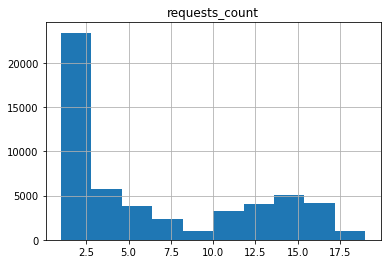

In [28]:
def requests_per_user(df):
    request_counts_df = pd.DataFrame(df.groupby(['ip', 'user_agent']).size(),
                        columns=['requests_count'])
    
    # plot the histogram for uesr with less than 20 requests
    request_counts_df[request_counts_df['requests_count'] < 20].hist(bins=10)
    
requests_per_user(df)
    

In [29]:
user_df = pd.DataFrame(df.groupby(['ip', 'user_agent']).size(),
                        columns=['requests_count'])

user_df.sort_values('requests_count', ascending=False)

,,requests_count
ip,user_agent,
20.92.247.146,sentry/21.4.1 (https://sentry.io),23912
207.213.207.102,Googlebot-Image/1.0,23627
207.213.207.116,Googlebot-Image/1.0,23380
207.213.207.130,Googlebot-Image/1.0,21494
207.213.207.144,Googlebot-Image/1.0,15362
...,...,...
35.195.33.229,Mozilla/5.0 (compatible; heritrix/3.4.0-20200304 +https://zarebin.ir/),1
35.195.33.187,Mozilla/5.0 (compatible; heritrix/3.4.0-20200304 +https://zarebin.ir/),1
35.195.31.184,okhttp/3.12.1,1


### 1.3.2 Std of path length per user
**Deeper requests usually indicates a human user.**


In [30]:
# set the path length for each request
df['url_length'] = df['url'].apply(lambda x : len(x.split('/')))
# create a dataframe that includes std of the path_lengths per user
user_df['url_length_std'] = df.groupby(['ip', 'user_agent'])['url_length'].agg('std')

user_df['url_length_std'] = user_df['url_length_std'].fillna(0)
user_df[user_df['requests_count'] > 5].sort_values(['url_length_std', 'requests_count'], ascending=True)

,,requests_count,url_length_std
ip,user_agent,,
102.24.134.34,MoziIIa/5.0 (X11; Linux x86_64) app_version: 735,6,0.000000
102.86.13.63,MoziIIa/5.0 (X11; Linux x86_64) app_version: 581,6,0.000000
102.86.6.9,"Mozilla/5.(Linux; Android 10; SAMSUNG SM-A217F) AppleWebKit/537.36 (KHTML, like Gecko) SamsungBrowser/11.Chrome/75.0.3770.143 Mobile Safari/537.36",6,0.000000
102.93.72.182,"Mozilla/5.(Linux; Android 8.1.0; DUB-LX1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.127 Mobile Safari/537.36",6,0.000000
11.127.239.60,Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:24.0) Gecko/20100101 Firefox/24.0,6,0.000000
...,...,...,...
35.54.12.42,"Mozilla/5.0 (Linux; Android 10; MAR-LX1M) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.106 Mobile Safari/537.36",6,1.722401
35.124.166.122,"Mozilla/5.0 (Linux; Android 8.1.0; SAMSUNG SM-J730F) AppleWebKit/537.36 (KHTML, like Gecko) SamsungBrowser/10.2 Chrome/71.0.3578.99 Mobile Safari/537.36",8,1.752549
60.92.118.166,"Mozilla/5.0 (Linux; Android 5.1.1; SM-G531H Build/LMY48B) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/46.0.2490.76 Mobile Safari/537.36",11,1.793929


### 1.3.3 Percentage of 4xx response codes per user
**Usually higher for crawlers as there is higher chances of hitting an outdated or deleted page.**

In [31]:
# fetch the requests with 4xx responses
resp_400 = df[df['status_code'] > 400]
# create a column in user_df dataframe as "4xx_counts" which includes the number of 4xx
# responses per user.
user_df['4xx_counts'] = resp_400.groupby(['ip', 'user_agent'])['status_code'].agg('size')
user_df['4xx_counts'] = user_df['4xx_counts'].fillna(0)

user_df['4xx_percentage(%)'] = (user_df['4xx_counts'] / user_df['requests_count']) * 100
# drop 4xx_counts column
user_df.drop(columns=['4xx_counts'], inplace=True)

user_df[user_df['requests_count'] > 5].sort_values(['4xx_percentage(%)', 'requests_count'], ascending=False)

,,requests_count,url_length_std,4xx_percentage(%)
ip,user_agent,,,
35.124.193.182,Dalvik/2.1.0 (Linux; U; Android 10; SM-A115F Build/QP1A.190711.020),104,0.000000,100.0
35.132.17.132,"Mozilla/5.(Linux; Android 6.0.1; SAMSUNG SM-J700F) AppleWebKit/537.36 (KHTML, like Gecko) SamsungBrowser/14.Chrome/87.0.4280.141 Mobile Safari/537.36",45,0.000000,100.0
153.126.209.239,Go-http-client/1.1,35,0.000000,100.0
35.202.101.118,"Mozilla/5.(Linux; Android 5.1.1; SAMSUNG SM-J111F) AppleWebKit/537.36 (KHTML, like Gecko) SamsungBrowser/13.2 Chrome/83.0.4103.106 Mobile Safari/537.36",22,0.000000,100.0
35.244.120.44,Go-http-client/1.1,18,0.000000,100.0
...,...,...,...,...
92.239.237.42,MoziIIa/5.0 (X11; Linux x86_64) app_version: 581,6,0.836660,0.0
92.239.251.224,"Mozilla/5.(Linux; Android 10; Redmi Note 9 Pro) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.101 Mobile Safari/537.36",6,0.000000,0.0
92.51.185.100,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.77 Safari/537.36",6,0.000000,0.0


### 1.3.3.1 Percentage of 3xx response codes per user
**Family 300 means redirecting to another page. Crawlers and bots usually face this response more often.**

In [32]:
# fetch the requests with 3xx responses
resp_300 = df[(df['status_code'] >= 300) & (df['status_code'] < 400)]
# create a column in user_df dataframe as "3xx_counts" which includes the number of 3xx
# responses per user.
user_df['3xx_counts'] = resp_300.groupby(['ip', 'user_agent'])['status_code'].agg('size')
user_df['3xx_counts'] = user_df['3xx_counts'].fillna(0)

user_df['3xx_percentage(%)'] = (user_df['3xx_counts'] / user_df['requests_count']) * 100
# drop 3xx_counts column
user_df.drop(columns=['3xx_counts'], inplace=True)

user_df[user_df['requests_count'] > 5].sort_values(['3xx_percentage(%)', 'requests_count'], ascending=False)

,,requests_count,url_length_std,4xx_percentage(%),3xx_percentage(%)
ip,user_agent,,,,
35.26.221.84,"Mozilla/5.(Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.101 Safari/537.36",4043,0.453993,0.0,100.0
35.125.194.34,"Mozilla/5.(Linux; Android 10; Redmi Note 9 Pro Max Build/QKQ1.191215.002) AppleWebKit/537.36 (KHTML, like Gecko) Soul/4.Chrome/91.0.4472.88 Mobile Safari/537.36",530,0.455319,0.0,100.0
207.213.193.143,"Mozilla/5.(Linux; Android 6.0.1; Nexus 5X Build/MMB29P) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.9Mobile Safari/537.36 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)",524,0.329976,0.0,100.0
35.117.109.145,"Mozilla/5.(Linux; Android 11; SM-A505F) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.101 Mobile Safari/537.36",424,0.292646,0.0,100.0
86.151.172.46,"Mozilla/5.(Linux; U; Android 7.0; en-US; TRT-L21A Build/HUAWEITRT-L21A) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.Chrome/78.0.3904.108 UCBrowser/13.3.8.1305 Mobile Safari/537.36",399,0.490717,0.0,100.0
...,...,...,...,...,...
92.239.17.78,MoziIIa/5.0 (X11; Linux x86_64) app_version: 581,6,0.836660,0.0,0.0
92.239.216.149,"Mozilla/5.0 (Linux; Android 9; SM-J701F) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.92 Mobile Safari/537.36",6,0.516398,0.0,0.0
92.239.237.42,MoziIIa/5.0 (X11; Linux x86_64) app_version: 581,6,0.836660,0.0,0.0


### 1.3.4 Percentage of HTTP HEAD requests, per user
**Indicates a web crawler, Because this type of user is more likely to encounter deleted or outdated pages.**

In [33]:
# fetch the requests with HEAD method
HTTP_HEAD = df[df['method'] == 'Head']
# create a column in user_df dataframe as "HEAD_count" which includes the number of HEAD
# requests per user.
user_df['HEAD_count'] = HTTP_HEAD.groupby(['ip', 'user_agent'])['method'].agg('size')
user_df['HEAD_count'] = user_df['HEAD_count'].fillna(0)

user_df['HEAD_count(%)'] = (user_df['HEAD_count'] / user_df['requests_count']) * 100
# drop HEAD_count column
user_df.drop(columns=['HEAD_count'], inplace=True)

user_df[user_df['requests_count'] > 5].sort_values(['HEAD_count(%)', 'requests_count'], ascending=False)

,,requests_count,url_length_std,4xx_percentage(%),3xx_percentage(%),HEAD_count(%)
ip,user_agent,,,,,
20.163.161.41,"Mozilla/5.(iPhone; CPU iPhone OS 7_like Mac OS X; en-us) AppleWebKit/537.51.1 (KHTML, like Gecko) Version/7.Mobile/11A465 Safari/9537.53",27,0.891556,0.000000,0.000000,100.000000
36.67.23.210,Go-http-client/2.0,7582,0.000000,1.609074,9.773147,45.805856
60.148.0.167,Go-http-client/2.0,7351,0.000000,1.714053,10.053054,43.980411
20.92.247.170,Go-http-client/2.0,7273,0.000000,0.000000,10.325863,42.334662
76.212.164.3,Go-http-client/2.0,6549,0.000000,1.878149,9.406016,42.113300
...,...,...,...,...,...,...
92.239.237.42,MoziIIa/5.0 (X11; Linux x86_64) app_version: 581,6,0.836660,0.000000,0.000000,0.000000
92.239.251.224,"Mozilla/5.(Linux; Android 10; Redmi Note 9 Pro) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.101 Mobile Safari/537.36",6,0.000000,0.000000,100.000000,0.000000
92.51.185.100,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.77 Safari/537.36",6,0.000000,0.000000,0.000000,0.000000


### 1.3.5 Percentage of image requests per user

**Web crawlers usually ignore images.**

In [34]:
# fetch the image requests
condition_1 = df['url'].str.contains('images',case=False)
condition_2 = df['url'].str.endswith('.png') | df['url'].str.endswith('.jpg')
image_requests = df[condition_1 | condition_2]
# create a column in user_df dataframe as "image_count" which contains the number of image
# requests per user.
user_df['image_count'] = image_requests.groupby(['ip', 'user_agent'])['url'].agg('size')
user_df['image_count'] = user_df['image_count'].fillna(0)

user_df['image_count(%)'] = (user_df['image_count'] / user_df['requests_count']) * 100
# drop image_count column
user_df.drop(columns=['image_count'], inplace=True)

user_df[user_df['requests_count'] > 20].sort_values(['image_count(%)', 'requests_count'], ascending=True).head(10)

,,requests_count,url_length_std,4xx_percentage(%),3xx_percentage(%),HEAD_count(%),image_count(%)
ip,user_agent,,,,,,
102.15.174.47,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.Safari/537.36",21,0.000000,0.0,0.0,0.0,0.0
102.29.29.19,MoziIIa/5.0 (X11; Linux x86_64) app_version: 581,21,0.000000,0.0,0.0,0.0,0.0
113.11.38.30,MoziIIa/5.0 (X11; Linux x86_64) app_version: 581,21,0.749603,0.0,0.0,0.0,0.0
113.111.195.219,MoziIIa/5.0 (X11; Linux x86_64) app_version: 581,21,0.000000,0.0,0.0,0.0,0.0
113.118.175.102,MoziIIa/5.0 (X11; Linux x86_64) app_version: 581,21,0.810643,0.0,0.0,0.0,0.0
113.118.45.106,okhttp/3.12.1,21,0.436436,0.0,0.0,0.0,0.0
113.118.90.28,MoziIIa/5.0 (X11; Linux x86_64) app_version: 581,21,0.810643,0.0,0.0,0.0,0.0
113.118.96.94,okhttp/3.12.1,21,0.358569,0.0,0.0,0.0,0.0
113.3.221.32,"Mozilla/5.0 (Linux; Android 10; SAMSUNG SM-G960W) AppleWebKit/537.36 (KHTML, like Gecko) SamsungBrowser/14.0 Chrome/87.0.4280.141 Mobile Safari/537.36",21,1.030488,0.0,0.0,0.0,0.0


### 1.3.6 Average and sum of the response length and response time per user

**Human users retrieve information from the Web via some interface, such as web browser. This interface forces the user's session to request additional resources automatically.**

In [35]:
df['response_time'] = df['response_time'].replace(0, "0")

In [36]:
user_df['total_response_length'] = df.groupby(['ip', 'user_agent'])['response_length'].agg('sum')
user_df['mean_response_length'] = df.groupby(['ip', 'user_agent'])['response_length'].agg('mean')

user_df['total_response_time'] = df.groupby(['ip', 'user_agent'])['response_time'].agg('sum')
user_df['mean_response_time'] = df.groupby(['ip', 'user_agent'])['response_time'].agg('mean')

user_df[(user_df['requests_count'] > 5) & 
        (user_df['3xx_percentage(%)'] < 20)].sort_values(
    by=['mean_response_time', 'mean_response_length'], ascending=True)

requests_count  \
ip             user_agent                                                           
35.68.179.172  Dalvik/2.1.0 (Linux; U; Android 6.0.1; SM-G532G...               6   
29.240.244.96  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1)...               8   
41.181.137.79  Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like Ma...               7   
35.115.88.26   Mozilla/5.(Windows NT 6.1; Win64; x64; rv:89.0)...               6   
35.220.5.0     MoziIIa/5.0 (X11; Linux x86_64) app_version: 735                 6   
...                                                                           ...   
92.239.237.207 MoziIIa/5.0 (X11; Linux x86_64) app_version: 581               792   
               okhttp/3.12.1                                                  714   
93.113.99.115  Go-http-client/2.0                                            5976   
99.197.134.27  Mozilla/5.0 (iPhone; CPU iPhone OS 14_3 like Ma...             166   
99.239.97.147  Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:89...             181   

                                                                   url_length_std  \
ip             user_agent                                                           
35.68.179.172  Dalvik/2.1.0 (Linux; U; Android 6.0.1; SM-G532G...        0.000000   
29.240.244.96  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1)...        0.000000   
41.181.137.79  Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like Ma...        0.000000   
35.115.88.26   Mozilla/5.(Windows NT 6.1; Win64; x64; rv:89.0)...        0.816497   
35.220.5.0     MoziIIa/5.0 (X11; Linux x86_64) app_version: 735          0.000000   
...                                                                           ...   
92.239.237.207 MoziIIa/5.0 (X11; Linux x86_64) app_version: 581          0.370593   
               okhttp/3.12.1                                             0.064729   
93.113.99.115  Go-http-client/2.0                                        0.000000   
99.197.134.27  Mozilla/5.0 (iPhone; CPU iPhone OS 14_3 like Ma...        0.951642   
99.239.97.147  Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:89...        0.899253   

                                                                   4xx_percentage(%)  \
ip             user_agent                                                              
35.68.179.172  Dalvik/2.1.0 (Linux; U; Android 6.0.1; SM-G532G...              100.0   
29.240.244.96  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1)...               75.0   
41.181.137.79  Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like Ma...                0.0   
35.115.88.26   Mozilla/5.(Windows NT 6.1; Win64; x64; rv:89.0)...              100.0   
35.220.5.0     MoziIIa/5.0 (X11; Linux x86_64) app_version: 735                  0.0   
...                                                                              ...   
92.239.237.207 MoziIIa/5.0 (X11; Linux x86_64) app_version: 581                  0.0   
               okhttp/3.12.1                                                     0.0   
93.113.99.115  Go-http-client/2.0                                                0.0   
99.197.134.27  Mozilla/5.0 (iPhone; CPU iPhone OS 14_3 like Ma...                0.0   
99.239.97.147  Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:89...                0.0   

                                                                   3xx_percentage(%)  \
ip             user_agent                                                              
35.68.179.172  Dalvik/2.1.0 (Linux; U; Android 6.0.1; SM-G532G...           0.000000   
29.240.244.96  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1)...           0.000000   
41.181.137.79  Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like Ma...           0.000000   
35.115.88.26   Mozilla/5.(Windows NT 6.1; Win64; x64; rv:89.0)...           0.000000   
35.220.5.0     MoziIIa/5.0 (X11; Linux x86_64) app_version: 735             0.000000   
...                                                                              ...   
92.239

### 1.3.7 Average of the path_count_normalized per user

In [37]:
user_df['avg_url_count_norm'] = df.groupby(['ip', 'user_agent'])['url_count_normalized'].agg('mean')

user_df[user_df['requests_count'] > 5].sort_values(['avg_url_count_norm'], ascending=True)

,,requests_count,url_length_std,4xx_percentage(%),3xx_percentage(%),HEAD_count(%),image_count(%),total_response_length,mean_response_length,total_response_time,mean_response_time,avg_url_count_norm
ip,user_agent,,,,,,,,,,,
113.97.198.0,okhttp/3.12.1,113,0.0,0.0,0.0,0.0,0.0,0313894589002037500413010025576000228940003907...,2.777828e+190,6000312724263311600066000663786600076000711241...,inf,0.000081
35.181.147.176,okhttp/3.12.1,7,0.0,0.0,0.0,0.0,0.0,121581137126015616001592311807,1.736873e+28,73622618199987873163600008219981567,1.051752e+34,0.000081
41.73.88.246,okhttp/3.12.1,6,0.0,0.0,0.0,0.0,0.0,1354328463139313149193709,2.257214e+23,1189626030368675119838270206155733,1.982710e+32,0.000081
113.135.12.103,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.Safari/537.36",6,0.0,0.0,0.0,0.0,0.0,444944452144475444854480599,7.415741e+25,3885955035143272737240705691078,6.476592e+29,0.000081
35.19.44.232,okhttp/3.12.1,15,0.0,0.0,0.0,0.0,0.0,36140279190281500423100000180973341,2.409352e+33,1169186000768123600076068760011600071245816000...,7.794573e+75,0.000081
...,...,...,...,...,...,...,...,...,...,...,...,...
148.254.70.145,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.101 Safari/537.36",24,0.0,0.0,0.0,0.0,0.0,2892892892892892892892892892892892892892892892...,1.205372e+70,1281632201612812820168812128121216816248,5.340134e+37,2.872202
209.193.195.194,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.101 Safari/537.36",8,0.0,0.0,0.0,0.0,0.0,289289289289289289289289,3.616116e+22,881288888,1.101611e+08,2.872202
113.118.17.144,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.101 Safari/537.36",6,0.0,0.0,0.0,0.0,0.0,289289289289289289,4.821488e+16,1284888,2.141480e+05,2.872202


### 1.3.7 Set the browser for each user agent

In [38]:
user_df = user_df.reset_index()

user_df['browser'] = user_df['user_agent'].apply(lambda x: parse(x).browser.family)
user_df['os'] = user_df['user_agent'].apply(lambda x: parse(x).os.family)
user_df['is_bot'] = user_df['user_agent'].apply(lambda x: parse(x).is_bot)
user_df['is_pc'] = user_df['user_agent'].apply(lambda x: parse(x).is_pc)

user_df.head(50)

,ip,user_agent,requests_count,url_length_std,4xx_percentage(%),3xx_percentage(%),HEAD_count(%),image_count(%),total_response_length,mean_response_length,total_response_time,mean_response_time,avg_url_count_norm,browser,os,is_bot,is_pc
0,1.56.57.214,Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like M...,1,0.000000,0.000000,0.000000,0.0,0.000000,79149,7.914900e+04,28,2.800000e+01,0.000161,Mobile Safari,iOS,False,False
1,1.66.71.34,Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like...,1,0.000000,0.000000,0.000000,0.0,0.000000,59156,5.915600e+04,28,2.800000e+01,0.002900,Mobile Safari,iOS,False,False
2,1.81.122.235,Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like M...,7,0.000000,0.000000,0.000000,0.0,0.000000,1011011488901157941352818036911361665868,1.444302e+38,44566428244828,6.366633e+12,0.002440,Mobile Safari,iOS,False,False
3,10.92.2.8,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,28,0.999338,0.000000,0.000000,0.0,28.571429,6800020142840012884570874743249441037403981691...,2.428579e+117,16048123288243216242832365624241620168810440044,5.731473e+44,0.726120,Samsung Internet,Android,False,False
4,100.92.35.41,Mozilla/5.0 (Linux; Android 9; SM-A205F) Apple...,12,1.311372,0.000000,0.000000,0.0,0.000000,30132301328667928400128845106908784996505930132,2.511025e+45,168168152122442820244,1.401401e+19,0.880021,Chrome Mobile,Android,False,False
5,102.0.21.98,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,1,0.000000,0.000000,0.000000,0.0,0.000000,81704,8.170400e+04,40,4.000000e+01,0.001369,Chrome,Windows,False,True
6,102.0.232.185,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,14,0.513553,0.000000,0.000000,0.0,0.000000,289662892896628966289662892898828988,2.069021e+34,12152305481126508113006411230212122314448256767,8.680218e+44,1.641293,Chrome,Windows,False,True
7,102.0.232.185,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2,0.000000,0.000000,0.000000,0.0,0.000000,7777,3.888500e+03,172905172373,8.645259e+10,0.000081,Chrome,Windows,False,True
8,102.0.232.220,Mozilla/5.0 (Linux; Android 11; SM-A505F) Appl...,14,0.363137,0.000000,0.000000,0.0,35.714286,5067150880308913320231069065059284008644771602...,3.619393e+68,20244161620121632882044,1.446012e+21,1.740692,Chrome Mobile,Android,False,False
9,102.0.68.163,Mozilla/5.(Linux; Android 10; STK-LX1) AppleWe...,10,0.316228,0.000000,100.000000,0.0,20.000000,0000000000,0.000000e+00,4448404044,4.448404e+08,2.092434,Chrome Mobile,Android,False,False


### 1.3.8 Number of *robots.txt* requests

**A nominal attribute with values of either 1 or 0, indicating whether ‘robot.txt’ file was requested or not requested by a user during a session, respectively. Web administrators, through the Robots Exclusion Protocol, use a special-format file called robots.txt to indicate to visiting robots which parts of their sites should not be visited by the robot.**

In [39]:
# fetch the robots.txt requests
user_df.set_index(['ip', 'user_agent'],inplace=True)
condition_1 = df['url'].str.contains('robots.txt',case=False).astype(bool)
robots_requests = df[condition_1]
# create a column in user_df dataframe as "robots_req_count" which contains the number of robots.txt requets
user_df['robots_txt_reqs'] = robots_requests.groupby(['ip', 'user_agent'])['url'].agg('size')
user_df['robots_txt_reqs'] = user_df['robots_txt_reqs'].fillna(0)
user_df.sort_values(
    by=['robots_txt_reqs'], ascending=False)

requests_count  \
ip              user_agent                                                           
67.149.194.62   Mozilla/5.0 (Windows NT 10.0; Win64; x64) Apple...              47   
79.130.18.121   Mozilla/5.0 (compatible; bingbot/2.0; +http://w...             237   
207.213.207.116 Mozilla/5.0 (compatible; Googlebot/2.1; +http:/...              45   
207.213.207.3   Mozilla/5.0 (compatible; Googlebot/2.1; +http:/...               4   
118.151.92.167  Mozilla/5.0 (compatible; MJ12bot/v1.4.8; http:/...               8   
...                                                                            ...   
246.135.230.223 Mozilla/5.0 (Linux; Android 11; SAMSUNG SM-A507...               1   
246.135.230.227 MoziIIa/5.0 (X11; Linux x86_64) app_version: 581                21   
                Mozilla/5.(Linux; Android 10; Redmi Note 9 Pro)...              11   
                Mozilla/5.0 (Linux; Android 10; Redmi Note 9 Pr...               1   
99.96.90.10     Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like Ma...               1   

                                                                    url_length_std  \
ip              user_agent                                                           
67.149.194.62   Mozilla/5.0 (Windows NT 10.0; Win64; x64) Apple...        0.905835   
79.130.18.121   Mozilla/5.0 (compatible; bingbot/2.0; +http://w...        0.564574   
207.213.207.116 Mozilla/5.0 (compatible; Googlebot/2.1; +http:/...        0.777200   
207.213.207.3   Mozilla/5.0 (compatible; Googlebot/2.1; +http:/...        0.000000   
118.151.92.167  Mozilla/5.0 (compatible; MJ12bot/v1.4.8; http:/...        0.000000   
...                                                                            ...   
246.135.230.223 Mozilla/5.0 (Linux; Android 11; SAMSUNG SM-A507...        0.000000   
246.135.230.227 MoziIIa/5.0 (X11; Linux x86_64) app_version: 581          0.000000   
                Mozilla/5.(Linux; Android 10; Redmi Note 9 Pro)...        0.301511   
                Mozilla/5.0 (Linux; Android 10; Redmi Note 9 Pr...        0.000000   
99.96.90.10     Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like Ma...        0.000000   

                                                                    4xx_percentage(%)  \
ip              user_agent                                                              
67.149.194.62   Mozilla/5.0 (Windows NT 10.0; Win64; x64) Apple...          14.893617   
79.130.18.121   Mozilla/5.0 (compatible; bingbot/2.0; +http://w...           0.000000   
207.213.207.116 Mozilla/5.0 (compatible; Googlebot/2.1; +http:/...           0.000000   
207.213.207.3   Mozilla/5.0 (compatible; Googlebot/2.1; +http:/...           0.000000   
118.151.92.167  Mozilla/5.0 (compatible; MJ12bot/v1.4.8; http:/...           0.000000   
...                                                                               ...   
246.135.230.223 Mozilla/5.0 (Linux; Android 11; SAMSUNG SM-A507...           0.000000   
246.135.230.227 MoziIIa/5.0 (X11; Linux x86_64) app_version: 581             0.000000   
                Mozilla/5.(Linux; Android 10; Redmi Note 9 Pro)...           0.000000   
                Mozilla/5.0 (Linux; Android 10; Redmi Note 9 Pr...           0.000000   
99.96.90.10     Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like Ma...           0.000000   

                                                                    3xx_percentage(%)  \
ip              user_agent                                                              
67.149.194.62   Mozilla/5.0 (Windows NT 10.0; Win64; x64) Apple...                0.0   
79.130.18.121   Mozilla/5.0 (compatible; bingbot/2.0; +http://w...                0.0   
207.213.207.116 Mozilla/5.0 (compatible; Googlebot/2.1; +http:/...                0.0   
207.213.207.3   Mozilla/5.0 (compatible; Googlebot/2.1; +http:/...              100.0   
118.151.92.167  Mozilla/5.0 (compatible; MJ12bot/v1.4.8; http:/...               25.0   
...                                              

### 1.3.9 Percentage of consecutive repeated HTTP requests per session

**A numerical attribute calculated as the number of repeated requests sent in sequence belonging to the same web directory sent by a user during a session.**

In [40]:
user_df['merged_urls']=df.groupby(['ip', 'user_agent'])['url'].apply(' '.join)

def consq_rep_reqs(merged_url):
    splited_urls = merged_url.split(" ")
    for idx in range(len(splited_urls)):
        splited_parts = splited_urls[idx].split("/")
        if len(splited_parts) > 1:
            splited_urls[idx] = "/".join(splited_parts[:-1])
    return len(np.unique(np.array(splited_urls)))
    

user_df['consq_rep_url_count'] = user_df['merged_urls'].apply(consq_rep_reqs)
user_df['consq_rep_url_count'] = user_df['requests_count'] - user_df['consq_rep_url_count']
user_df['consq_rep_url_count'] = (user_df['consq_rep_url_count'] / user_df['requests_count'])*100
user_df.drop(columns='merged_urls', axis=1,inplace=True)

user_df.sort_values('consq_rep_url_count',ascending=False).head(50)


,,requests_count,url_length_std,4xx_percentage(%),3xx_percentage(%),HEAD_count(%),image_count(%),total_response_length,mean_response_length,total_response_time,mean_response_time,avg_url_count_norm,browser,os,is_bot,is_pc,robots_txt_reqs,consq_rep_url_count
ip,user_agent,,,,,,,,,,,,,,,,,
20.92.247.146,sentry/21.4.1 (https://sentry.io),23912,0.040370,0.012546,0.000000,0.000000,0.000000,1079701079701079701079701079701079707673207673...,inf,1620482024108202416484448848248824488441612824...,inf,1.393890,Other,Other,False,False,0.0,99.983272
36.67.23.210,Go-http-client/2.0,7582,0.000000,1.609074,9.773147,45.805856,0.000000,0120101201000633791201012010012011201012010006...,inf,2820208243212440200202008964202812480202481632...,inf,1.993947,Go-http-client,Other,False,False,0.0,99.973622
60.148.0.167,Go-http-client/2.0,7351,0.000000,1.714053,10.053054,43.980411,0.000000,1201001201001201012010063379120101201012010120...,inf,0286042428424432848024121642004522842042442002...,inf,1.969884,Go-http-client,Other,False,False,0.0,99.972793
20.92.247.170,Go-http-client/2.0,7273,0.000000,0.000000,10.325863,42.334662,0.000000,0063379120101201012010012010012016337900633790...,inf,2485601644082020161681240288324361628161642812...,inf,1.987855,Go-http-client,Other,False,False,0.0,99.972501
76.212.164.3,Go-http-client/2.0,6549,0.000000,1.878149,9.406016,42.113300,0.000000,0120101201063379012010012011201000120106337901...,inf,2042880443283224882442844242482882448368161232...,inf,1.941409,Go-http-client,Other,False,False,0.0,99.969461
20.116.215.189,Go-http-client/2.0,6401,0.000000,0.000000,9.576629,41.696610,0.000000,1201012010012010120106337901201012010120101201...,inf,0324242801684203602482441616082024416020420204...,inf,1.977870,Go-http-client,Other,False,False,0.0,99.968755
20.117.146.75,Go-http-client/2.0,6067,0.000000,0.000000,10.004945,40.168123,0.000000,1201063379012010120101201012010633790120101201...,inf,1243624428428820446024420420161642802412168281...,inf,1.960191,Go-http-client,Other,False,False,0.0,99.967035
93.113.99.115,Go-http-client/2.0,5976,0.000000,0.000000,10.090361,39.909639,0.000000,0120101201063379120101201012010120100633791201...,inf,2441242012402816324288288320284244202004244201...,inf,1.957237,Go-http-client,Other,False,False,0.0,99.966533
20.184.209.90,Go-http-client/2.0,2412,0.000000,0.000000,0.000000,0.000000,0.000000,6337963379633796337963379633796337963379633796...,inf,4420242840244056202820283260324844202816564024...,inf,2.671216,Go-http-client,Other,False,False,0.0,99.958541


# Generate DF

In [41]:
X = user_df.copy()
X.head(2)

,,requests_count,url_length_std,4xx_percentage(%),3xx_percentage(%),HEAD_count(%),image_count(%),total_response_length,mean_response_length,total_response_time,mean_response_time,avg_url_count_norm,browser,os,is_bot,is_pc,robots_txt_reqs,consq_rep_url_count
ip,user_agent,,,,,,,,,,,,,,,,,
1.56.57.214,"Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.1.1 Mobile/15E148 Safari/604.1",1,0.0,0.0,0.0,0.0,0.0,79149,79149.0,28,28.0,0.000161,Mobile Safari,iOS,False,False,0.0,0.0
1.66.71.34,"Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Mobile/15E148 Safari/604.1",1,0.0,0.0,0.0,0.0,0.0,59156,59156.0,28,28.0,0.002900,Mobile Safari,iOS,False,False,0.0,0.0


In [42]:
session_df = user_df.copy()
session_df.head(2)

,,requests_count,url_length_std,4xx_percentage(%),3xx_percentage(%),HEAD_count(%),image_count(%),total_response_length,mean_response_length,total_response_time,mean_response_time,avg_url_count_norm,browser,os,is_bot,is_pc,robots_txt_reqs,consq_rep_url_count
ip,user_agent,,,,,,,,,,,,,,,,,
1.56.57.214,"Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.1.1 Mobile/15E148 Safari/604.1",1,0.0,0.0,0.0,0.0,0.0,79149,79149.0,28,28.0,0.000161,Mobile Safari,iOS,False,False,0.0,0.0
1.66.71.34,"Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Mobile/15E148 Safari/604.1",1,0.0,0.0,0.0,0.0,0.0,59156,59156.0,28,28.0,0.002900,Mobile Safari,iOS,False,False,0.0,0.0


In [43]:
requests_df = df.copy()
requests_df.head(2)

,ip,time,method,url,requested_file_type,status_code,response_length,user_agent,response_time,label,url_count_normalized,browser,os,is_bot,is_pc,browser_norm,os_norm,url_length
0,207.213.193.143,2021-5-12T5:6:0.0+0430,Get,/cdn/profiles/1026106239,png,304,0,Googlebot-Image/1.0,32,1,0.011439,Googlebot-Image,Other,True,False,10.690666,21.747858,4
1,207.213.193.143,2021-5-12T5:6:0.0+0430,Get,images/badge.png,png,304,0,Googlebot-Image/1.0,4,1,1.009601,Googlebot-Image,Other,True,False,10.690666,21.747858,2


In [44]:
X = X.drop(['total_response_length', 'mean_response_length', 'total_response_time', 'mean_response_time'], axis = 1)
X

requests_count  \
ip            user_agent                                                           
1.56.57.214   Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like Ma...               1   
1.66.71.34    Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like ...               1   
1.81.122.235  Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like Ma...               7   
10.92.2.8     Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-A...              28   
100.92.35.41  Mozilla/5.0 (Linux; Android 9; SM-A205F) AppleW...              12   
...                                                                          ...   
99.239.78.14  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Apple...              22   
              Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleW...              21   
99.239.97.147 Mozilla/5.(Windows NT 10.0; Win64; x64; rv:89.0...              46   
              Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:89...             181   
99.96.90.10   Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like Ma...               1   

                                                                  url_length_std  \
ip            user_agent                                                           
1.56.57.214   Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like Ma...        0.000000   
1.66.71.34    Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like ...        0.000000   
1.81.122.235  Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like Ma...        0.000000   
10.92.2.8     Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-A...        0.999338   
100.92.35.41  Mozilla/5.0 (Linux; Android 9; SM-A205F) AppleW...        1.311372   
...                                                                          ...   
99.239.78.14  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Apple...        0.726731   
              Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleW...        0.643650   
99.239.97.147 Mozilla/5.(Windows NT 10.0; Win64; x64; rv:89.0...        0.514993   
              Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:89...        0.899253   
99.96.90.10   Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like Ma...        0.000000   

                                                                  4xx_percentage(%)  \
ip            user_agent                                                              
1.56.57.214   Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like Ma...           0.000000   
1.66.71.34    Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like ...           0.000000   
1.81.122.235  Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like Ma...           0.000000   
10.92.2.8     Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-A...           0.000000   
100.92.35.41  Mozilla/5.0 (Linux; Android 9; SM-A205F) AppleW...           0.000000   
...                                                                             ...   
99.239.78.14  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Apple...           0.000000   
              Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleW...           0.000000   
99.239.97.147 Mozilla/5.(Windows NT 10.0; Win64; x64; rv:89.0...           4.347826   
              Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:89...           0.000000   
99.96.90.10   Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like Ma...           0.000000   

                                                                  3xx_percentage(%)  \
ip            user_agent                                                              
1.56.57.214   Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like Ma...           0.000000   
1.66.71.34    Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like ...           0.000000   
1.81.122.235  Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like Ma...           0.000000   
10.92.2.8     Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-A...           0.000000   
100.92.35.41  Mozilla/5.0 (Linux; Android 9; SM-A205F) AppleW...           0.000000   
...                                                                             ...   
99.239.78.14  Mozilla/5.0 (Windows NT 10.0; Win64; x

## Normalize

In [45]:
to_be_normalized = [
                            'requests_count',
                            '3xx_percentage(%)',
                            '4xx_percentage(%)',
                            'HEAD_count(%)',
                            'image_count(%)',
                            'robots_txt_reqs',
                            'consq_rep_url_count'
]

In [46]:
scaler = StandardScaler()

In [47]:
X[to_be_normalized] = scaler.fit_transform(X[to_be_normalized])

In [48]:
X.drop(['browser', 'os'], axis=1, inplace=True)
X['is_bot'] = X['is_bot'].astype(int)
X['is_pc'] = X['is_pc'].astype(int)

In [49]:
X.head()

,,requests_count,url_length_std,4xx_percentage(%),3xx_percentage(%),HEAD_count(%),image_count(%),avg_url_count_norm,is_bot,is_pc,robots_txt_reqs,consq_rep_url_count
ip,user_agent,,,,,,,,,,,
1.56.57.214,"Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.1.1 Mobile/15E148 Safari/604.1",-0.079197,0.000000,-0.103202,-0.544286,-0.019993,-0.837766,0.000161,0,0,-0.03374,-1.291860
1.66.71.34,"Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Mobile/15E148 Safari/604.1",-0.079197,0.000000,-0.103202,-0.544286,-0.019993,-0.837766,0.002900,0,0,-0.03374,-1.291860
1.81.122.235,"Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.1.1 Mobile/15E148 Safari/604.1",-0.052356,0.000000,-0.103202,-0.544286,-0.019993,-0.837766,0.002440,0,0,-0.03374,1.358380
10.92.2.8,"Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-A500H) AppleWebKit/537.36 (KHTML, like Gecko) SamsungBrowser/14.0 Chrome/87.0.4280.141 Mobile Safari/537.36",0.041589,0.999338,-0.103202,-0.544286,-0.019993,0.189199,0.726120,0,0,-0.03374,0.916673
100.92.35.41,"Mozilla/5.0 (Linux; Android 9; SM-A205F) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.101 Mobile Safari/537.36",-0.029988,1.311372,-0.103202,-0.544286,-0.019993,-0.837766,0.880021,0,0,-0.03374,0.254113


In [50]:
cols = X.columns[:15]

X = X[cols]
X.head(10)

requests_count  \
ip            user_agent                                                           
1.56.57.214   Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like Ma...       -0.079197   
1.66.71.34    Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like ...       -0.079197   
1.81.122.235  Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like Ma...       -0.052356   
10.92.2.8     Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-A...        0.041589   
100.92.35.41  Mozilla/5.0 (Linux; Android 9; SM-A205F) AppleW...       -0.029988   
102.0.21.98   Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleW...       -0.079197   
102.0.232.185 Mozilla/5.0 (Windows NT 10.0; Win64; x64) Apple...       -0.021041   
              Mozilla/5.0 (Windows NT 10.0; Win64; x64) Apple...       -0.074724   
102.0.232.220 Mozilla/5.0 (Linux; Android 11; SM-A505F) Apple...       -0.021041   
102.0.68.163  Mozilla/5.(Linux; Android 10; STK-LX1) AppleWeb...       -0.038935   

                                                                  url_length_std  \
ip            user_agent                                                           
1.56.57.214   Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like Ma...        0.000000   
1.66.71.34    Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like ...        0.000000   
1.81.122.235  Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like Ma...        0.000000   
10.92.2.8     Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-A...        0.999338   
100.92.35.41  Mozilla/5.0 (Linux; Android 9; SM-A205F) AppleW...        1.311372   
102.0.21.98   Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleW...        0.000000   
102.0.232.185 Mozilla/5.0 (Windows NT 10.0; Win64; x64) Apple...        0.513553   
              Mozilla/5.0 (Windows NT 10.0; Win64; x64) Apple...        0.000000   
102.0.232.220 Mozilla/5.0 (Linux; Android 11; SM-A505F) Apple...        0.363137   
102.0.68.163  Mozilla/5.(Linux; Android 10; STK-LX1) AppleWeb...        0.316228   

                                                                  4xx_percentage(%)  \
ip            user_agent                                                              
1.56.57.214   Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like Ma...          -0.103202   
1.66.71.34    Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like ...          -0.103202   
1.81.122.235  Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like Ma...          -0.103202   
10.92.2.8     Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-A...          -0.103202   
100.92.35.41  Mozilla/5.0 (Linux; Android 9; SM-A205F) AppleW...          -0.103202   
102.0.21.98   Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleW...          -0.103202   
102.0.232.185 Mozilla/5.0 (Windows NT 10.0; Win64; x64) Apple...          -0.103202   
              Mozilla/5.0 (Windows NT 10.0; Win64; x64) Apple...          -0.103202   
102.0.232.220 Mozilla/5.0 (Linux; Android 11; SM-A505F) Apple...          -0.103202   
102.0.68.163  Mozilla/5.(Linux; Android 10; STK-LX1) AppleWeb...          -0.103202   

                                                                  3xx_percentage(%)  \
ip            user_agent                                                              
1.56.57.214   Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like Ma...          -0.544286   
1.66.71.34    Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like ...          -0.544286   
1.81.122.235  Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like Ma...          -0.544286   
10.92.2.8     Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-A...          -0.544286   
100.92.35.41  Mozilla/5.0 (Linux; Android 9; SM-A205F) AppleW...          -0.544286   
102.0.21.98   Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleW...          -0.544286   
102.0.232.185 Mozilla/5.0 (Windows NT 10.0; Win64; x64) Apple...          -0.544286   
              Mozilla/5.0 (Windows NT 10.0; Win64; x64) Apple...          -0.544286   
102.0.232.220 Mozilla/5.0 (Linux; Android 11; SM-A505F) Apple...          -0.544286   
102.0.68.163  Mozilla/5.(Linux; Android 10; ST

In [51]:
session_df.reset_index(inplace=True)
X.reset_index(inplace=True)

In [52]:
X.head(2)

,ip,user_agent,requests_count,url_length_std,4xx_percentage(%),3xx_percentage(%),HEAD_count(%),image_count(%),avg_url_count_norm,is_bot,is_pc,robots_txt_reqs,consq_rep_url_count
0,1.56.57.214,Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like M...,-0.079197,0.0,-0.103202,-0.544286,-0.019993,-0.837766,0.000161,0,0,-0.03374,-1.29186
1,1.66.71.34,Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like...,-0.079197,0.0,-0.103202,-0.544286,-0.019993,-0.837766,0.002900,0,0,-0.03374,-1.29186


# 1. IsolationForest

In [53]:
to_model_cols = X.columns[3:]

if_model = IsolationForest(bootstrap=False,
                     #bootstrap: randomly re-sample initial sample with replacement
                     contamination=float(.12),
                     #contamination: % of outliers (if known), no effect on score
                     max_features=1.0,
                     #max_features: # of randomly selected features at each node
                     max_samples='auto',
                     #max_samples: # of samples to draw from the initial samples 
                     #for each tree
                     n_estimators=200,
                     #n_estimators: # of trees in the forest
                     n_jobs=-1,
                     #n_jobs: # of cores used for parallelization, -1 means max available
                     random_state=42,
                     #random_state: sets the seed for reproducibility
                     verbose=0,
                     #verbose: control the verbosity of the output
                     warm_start=False)
                     #warm_start: reuse the solution from the previous call 
                     #and add more trees to the old ensemble
        
if_model.fit(X[to_model_cols])

y_pred = if_model.predict(X[to_model_cols])
y_score = if_model.decision_function(X[to_model_cols])
X['anomaly'] = y_pred

# result dataframe with columns : score and prediction
result_df = pd.DataFrame(if_model.decision_function(X[to_model_cols]), 
            columns=['score'])
result_df['prediction'] = y_pred

outliers = X.loc[X['anomaly'] == -1]
inliers = X.loc[X['anomaly'] == 1]

outlier_index = list(outliers.index)
inlier_index = list(inliers.index)

print(X['anomaly'].value_counts())
print("Note: -1 indicates anomaly")

C:\Users\hossein\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


 1    58568
-1     7804
Name: anomaly, dtype: int64
Note: -1 indicates anomaly


In [54]:
anomalies = session_df.loc[X.loc[X['anomaly'] == -1].index]
non_anomalies = session_df.loc[X.loc[X['anomaly'] == 1].index]


print("Number of anomalies with is_bot == True: {}".format(len(anomalies[anomalies['is_bot'] == True])))
print("Number of non-anomalies with is_bot == True: {}".format(len(non_anomalies[non_anomalies['is_bot'] == True])))

Number of anomalies with is_bot == True: 1466
Number of non-anomalies with is_bot == True: 0


In [55]:
result_df[result_df['score'] < 0]

,score,prediction
16,-0.056925,-1
18,-0.004809,-1
22,-0.078731,-1
29,-0.017609,-1
35,-0.092583,-1
...,...,...
66344,-0.078731,-1
66360,-0.030542,-1
66364,-0.010269,-1
66365,-0.071264,-1


<AxesSubplot:>

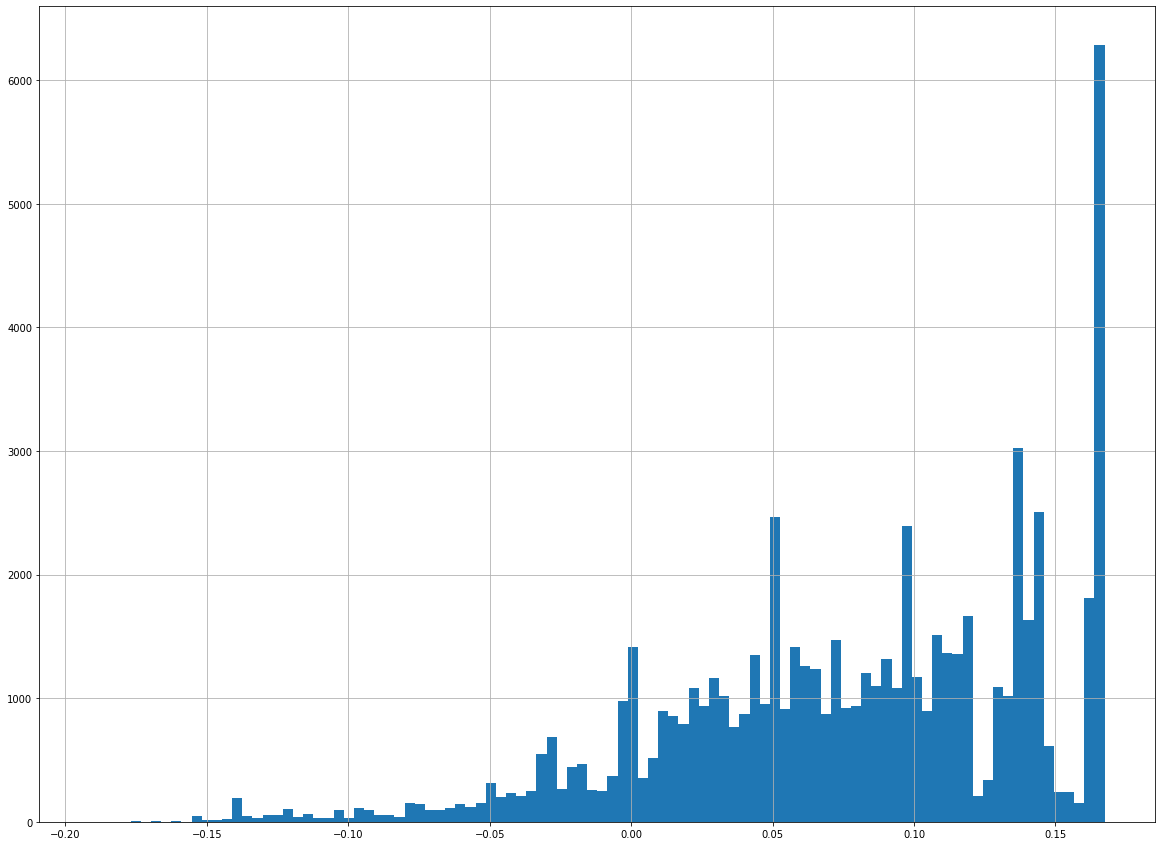

In [56]:
result_df['score'].hist(bins=100, figsize=(20,15))

In [57]:
top_anomalies = session_df.loc[result_df[result_df['prediction'] == -1].sort_values(['score'], ascending=True).index]
top_non_anomalies = session_df.loc[result_df[result_df['prediction'] == 1].sort_values(['score'], ascending=False).index]

ip = top_non_anomalies.iloc[-1000].ip
ua = top_non_anomalies.iloc[-1000].user_agent

requests_df[(requests_df['ip'] == ip) & (requests_df['user_agent'] == ua)].head(20)


,ip,time,method,url,requested_file_type,status_code,response_length,user_agent,response_time,label,url_count_normalized,browser,os,is_bot,is_pc,browser_norm,os_norm,url_length
799491,4.75.209.92,2021-5-12T12:51:21.0+0430,Get,images/window_screen_banner.png,png,200,39890,Mozilla/5.0 (Linux; Android 10; Nokia 1) Apple...,8,0,0.681982,Chrome Mobile,Android,False,False,31.322188,48.631042,2


In [58]:
#%matplotlib notebook

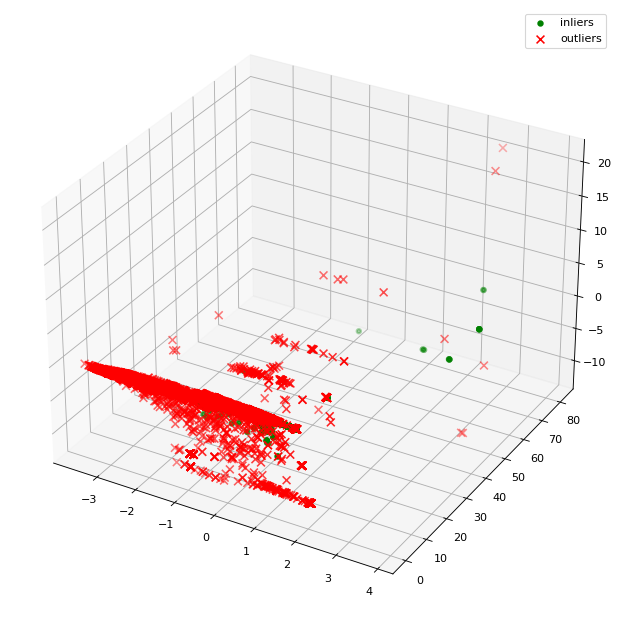

In [59]:
#X_sample = X.sample(n=10000, random_state=42)


pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
#X_norm = scaler.fit_transform(X[to_model_cols])

X_reduce = pca.fit_transform(X[to_model_cols])

fig = plt.figure(figsize=(10,10), dpi=80)
ax = fig.add_subplot(111, projection='3d')

# Plot the compressed data points
ax.scatter(X_reduce[inlier_index, 0], X_reduce[inlier_index, 1], zs=X_reduce[inlier_index, 2], 
           s=14, lw=2, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=10, s=1, marker="x", c="red", label="outliers")

ax.legend()
plt.show()

# 2. LocalOutlierFactor

In [60]:
X.drop(columns=['anomaly'], inplace=True)

In [61]:
lof = LocalOutlierFactor(n_neighbors=3)

to_model_cols = X.columns[3:]


pred = lof.fit_predict(X[to_model_cols])

X['anomaly'] = pred

outliers = X.loc[X['anomaly'] == -1]
inliers = X.loc[X['anomaly'] == 1]

outlier_index = list(outliers.index)
inlier_index = list(inliers.index)

print(X['anomaly'].value_counts())

 1    60145
-1     6227
Name: anomaly, dtype: int64


In [62]:
anomalies = X.loc[X.loc[X['anomaly'] == -1].index]
non_anomalies = X.loc[X.loc[X['anomaly'] == 1].index]
print(len(anomalies[anomalies['is_bot'] == True]))
print(len(non_anomalies[non_anomalies['is_bot'] == True]))

264
1202


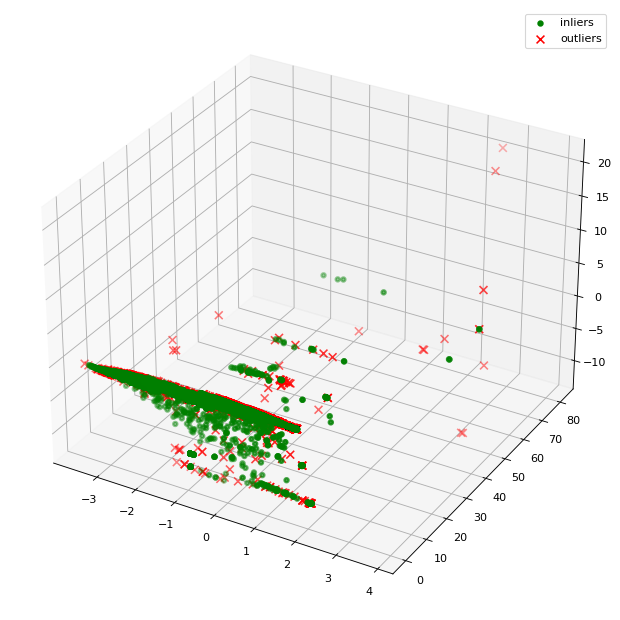

In [63]:
pca = PCA(n_components=3) 
scaler = StandardScaler()
#X_norm = scaler.fit_transform(X[to_model_cols])

X_reduce = pca.fit_transform(X[to_model_cols])

fig = plt.figure(figsize=(10,10), dpi=80)
ax = fig.add_subplot(111, projection='3d')

# Plot the compressed data points
ax.scatter(X_reduce[inlier_index, 0], X_reduce[inlier_index, 1], zs=X_reduce[inlier_index, 2], 
           s=14, lw=2, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=10, s=1, marker="x", c="red", label="outliers")

ax.legend()
plt.show()

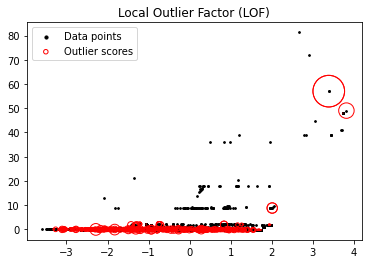

In [64]:
pca = PCA(n_components=2)  
X_reduce = pca.fit_transform(X[to_model_cols])
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X_reduce[:, 0], X_reduce[:, 1], color="k", s=3.0, label="Data points")
X_scores = lof.negative_outlier_factor_
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(
    X_reduce[:, 0],
    X_reduce[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
legend = plt.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]


## Clustering

In [65]:
X2 = X[X.columns[2:10]].copy()
X2.head(1)

,requests_count,url_length_std,4xx_percentage(%),3xx_percentage(%),HEAD_count(%),image_count(%),avg_url_count_norm,is_bot
0,-0.079197,0.0,-0.103202,-0.544286,-0.019993,-0.837766,0.000161,0


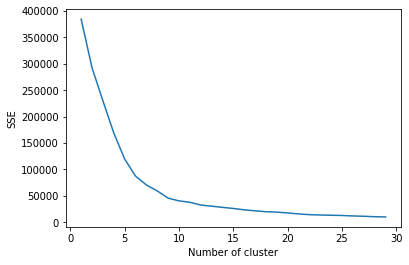

In [66]:
sse = {}
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k, max_iter=500).fit(X2)
    X2["cluster"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

best k is 5

In [67]:
best_k = 5

kmeans = KMeans(n_clusters=best_k, max_iter=1000).fit(X2)
X2["cluster"] = kmeans.labels_
X2

,requests_count,url_length_std,4xx_percentage(%),3xx_percentage(%),HEAD_count(%),image_count(%),avg_url_count_norm,is_bot,cluster
0,-0.079197,0.000000,-0.103202,-0.544286,-0.019993,-0.837766,0.000161,0,0
1,-0.079197,0.000000,-0.103202,-0.544286,-0.019993,-0.837766,0.002900,0,0
2,-0.052356,0.000000,-0.103202,-0.544286,-0.019993,-0.837766,0.002440,0,0
3,0.041589,0.999338,-0.103202,-0.544286,-0.019993,0.189199,0.726120,0,3
4,-0.029988,1.311372,-0.103202,-0.544286,-0.019993,-0.837766,0.880021,0,4
...,...,...,...,...,...,...,...,...,...
66367,0.014748,0.726731,-0.103202,-0.544286,-0.019993,0.796043,1.352020,0,2
66368,0.010274,0.643650,-0.103202,-0.544286,-0.019993,0.873843,1.415297,0,2
66369,0.122113,0.514993,0.419649,1.653741,-0.019993,0.959424,1.595760,0,4
66370,0.726045,0.899253,-0.103202,-0.544286,-0.019993,-0.103004,1.142844,0,3


In [68]:
X2.reset_index(inplace=True)
X2

,index,requests_count,url_length_std,4xx_percentage(%),3xx_percentage(%),HEAD_count(%),image_count(%),avg_url_count_norm,is_bot,cluster
0,0,-0.079197,0.000000,-0.103202,-0.544286,-0.019993,-0.837766,0.000161,0,0
1,1,-0.079197,0.000000,-0.103202,-0.544286,-0.019993,-0.837766,0.002900,0,0
2,2,-0.052356,0.000000,-0.103202,-0.544286,-0.019993,-0.837766,0.002440,0,0
3,3,0.041589,0.999338,-0.103202,-0.544286,-0.019993,0.189199,0.726120,0,3
4,4,-0.029988,1.311372,-0.103202,-0.544286,-0.019993,-0.837766,0.880021,0,4
...,...,...,...,...,...,...,...,...,...,...
66367,66367,0.014748,0.726731,-0.103202,-0.544286,-0.019993,0.796043,1.352020,0,2
66368,66368,0.010274,0.643650,-0.103202,-0.544286,-0.019993,0.873843,1.415297,0,2
66369,66369,0.122113,0.514993,0.419649,1.653741,-0.019993,0.959424,1.595760,0,4
66370,66370,0.726045,0.899253,-0.103202,-0.544286,-0.019993,-0.103004,1.142844,0,3
